In [37]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action="ignore")

In [39]:
def outlier_cut(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return np.where(data > upper_bound, upper_bound, np.where(data < lower_bound, lower_bound, data))

In [41]:
def apply_log_transform(df, add_constant=1):
    for col in get_numerical_features(df):
        df[col] = np.log(df[col] + add_constant)

    return df

In [43]:
def get_categorical_features(df, nunique_threshold=20):
    return [feature for feature in df.columns 
            if df[feature].nunique() < nunique_threshold]

In [45]:
def get_numerical_features(df, nunique_threshold=20):
    return [feature for feature in df.select_dtypes(include=[np.number]).columns 
            if df[feature].nunique() >= nunique_threshold]

In [47]:
def agg_data(data, prefix=''):
    numeric_cols = data.select_dtypes(include=['number']).columns.tolist()

    features = data[numeric_cols].groupby('SK_ID_CURR').agg(['mean', 'sum', 'max', 'min']).reset_index()
    features.columns = [prefix + '_'.join(col).strip() for col in features.columns.values]

    features.rename(columns={prefix + 'SK_ID_CURR_': 'SK_ID_CURR'} ,inplace=True)

    return(features)


In [49]:
def bar_plot(df, column, hue=None, size=(6, 6), title=None):
    if not title:
        title = f'Distribution of {column}'
    plt.figure(figsize=size)
    ax = sns.countplot(data=df, x=column, hue=hue)
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{100 * height / total:.1f}%'
        ax.text(p.get_x() + p.get_width() / 2, height / 2, percentage, ha='center', va='center', fontsize=10, color='white')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

In [51]:
def missing_plot(data, size=(12, 5)):
    missing = pd.DataFrame((data.isnull().sum()) * 100 / len(data)).reset_index()
    plt.figure(figsize=size)
    sns.set(style="ticks", rc={"lines.linewidth": 0.7})
    ax = sns.pointplot(x='index', y=0, data=missing)
    plt.xticks(rotation=90)
    plt.title('Percentage of Null Values')
    plt.ylabel('Percentage')
    plt.show()


In [55]:
train = pd.read_csv('data/application_train.csv')
test = pd.read_csv('data/application_test.csv')
bureau = pd.read_csv('data/bureau.csv')
bureau_balance = pd.read_csv('data/bureau_balance.csv')
pos_cash = pd.read_csv('data/POS_CASH_balance.csv')
credit_card = pd.read_csv('data/credit_card_balance.csv')
installments = pd.read_csv('data/installments_payments.csv')

In [57]:
combined_data = pd.concat([train, test], axis=0)
combined_data_encoded = pd.get_dummies(combined_data)

In [59]:
train_preprocesed = combined_data_encoded.iloc[:len(train)]
test_preprocesed = combined_data_encoded.iloc[len(train):].drop(columns=['TARGET'])

In [61]:
bureau_features = agg_data(bureau)

In [63]:
train_preprocesed = train_preprocesed.merge(bureau_features, on='SK_ID_CURR', how='left')
test_preprocesed = test_preprocesed.merge(bureau_features, on='SK_ID_CURR', how='left')

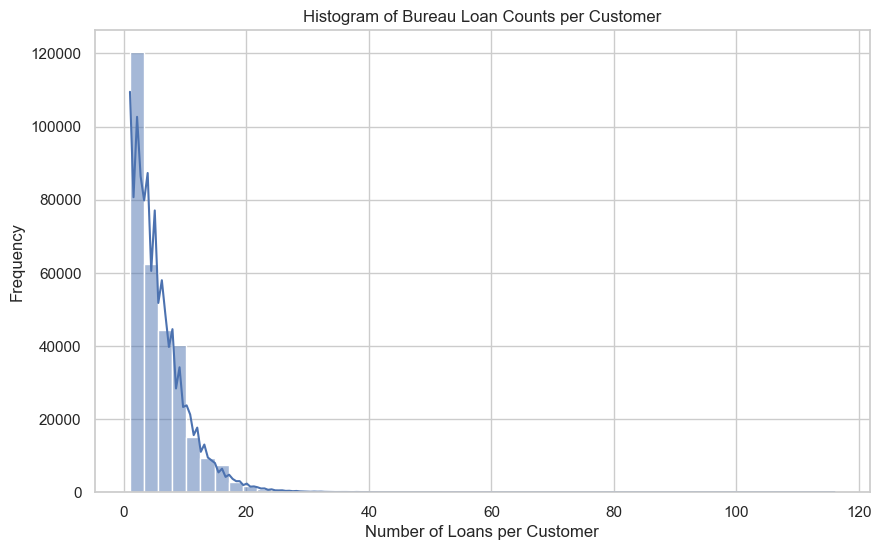

In [65]:
plt.figure(figsize=(10, 6))
sns.histplot(bureau['SK_ID_CURR'].value_counts(), bins=50, kde=True)
plt.title('Histogram of Bureau Loan Counts per Customer')
plt.xlabel('Number of Loans per Customer')
plt.ylabel('Frequency')
plt.show()

In [67]:
pos_features = agg_data(pos_cash, 'POS_')

In [69]:
train_preprocesed = train_preprocesed.merge(pos_features, on='SK_ID_CURR', how='left')
test_preprocesed = test_preprocesed.merge(pos_features, on='SK_ID_CURR', how='left')

In [71]:
credit_card_features = agg_data(credit_card, 'CC_')

In [73]:
train_preprocesed = train_preprocesed.merge(credit_card_features, on='SK_ID_CURR', how='left')
test_preprocesed = test_preprocesed.merge(credit_card_features, on='SK_ID_CURR', how='left')

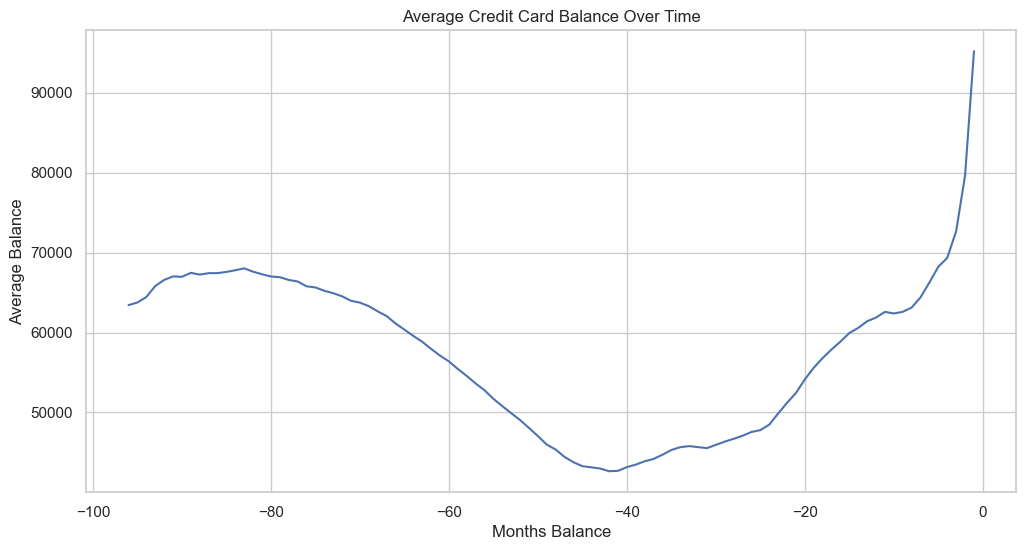

In [75]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=credit_card.groupby('MONTHS_BALANCE')['AMT_BALANCE'].mean())
plt.title('Average Credit Card Balance Over Time')
plt.xlabel('Months Balance')
plt.ylabel('Average Balance')
plt.show()

In [77]:
installments_features = agg_data(installments, 'INS_')

In [79]:
train_preprocesed = train_preprocesed.merge(installments_features, on='SK_ID_CURR', how='left')
test_preprocesed = test_preprocesed.merge(installments_features, on='SK_ID_CURR', how='left')

In [81]:
train_preprocesed.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in train_preprocesed.columns]
test_preprocesed.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in test_preprocesed.columns]

In [83]:
ids = [i for i in train_preprocesed if 'ID' in i and not i == 'SK_ID_CURR']

In [85]:
train_preprocesed.drop(columns=ids, inplace=True)
test_preprocesed.drop(columns=ids, inplace=True)

In [87]:
traget_corr = train_preprocesed.corr()['TARGET']

In [91]:
top30 = list(abs(traget_corr).sort_values(ascending=False)[:31].index) + ['SK_ID_CURR']

In [93]:
train_data = train_preprocesed[top30].copy()
test_data = test_preprocesed[top30[1:]].copy()

<Axes: >

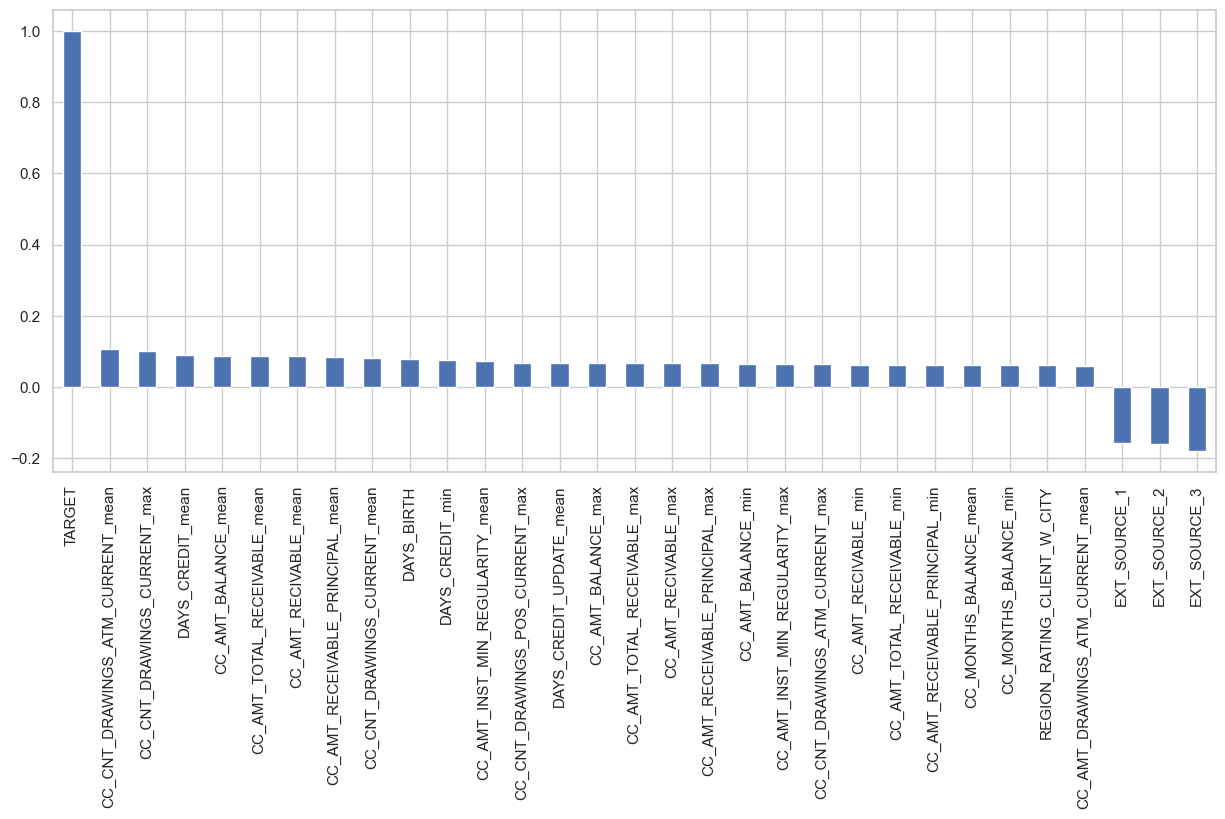

In [95]:
plt.figure(figsize=(15,6))
traget_corr[top30].drop('SK_ID_CURR').sort_values(ascending=False).plot(kind='bar', label=False)

In [97]:
for i in train_data.dtypes[train_data.dtypes == bool].index:
    train_data[i] = train_data[i].astype(np.int64)
    test_data[i] = test_data[i].astype(np.int64)
    

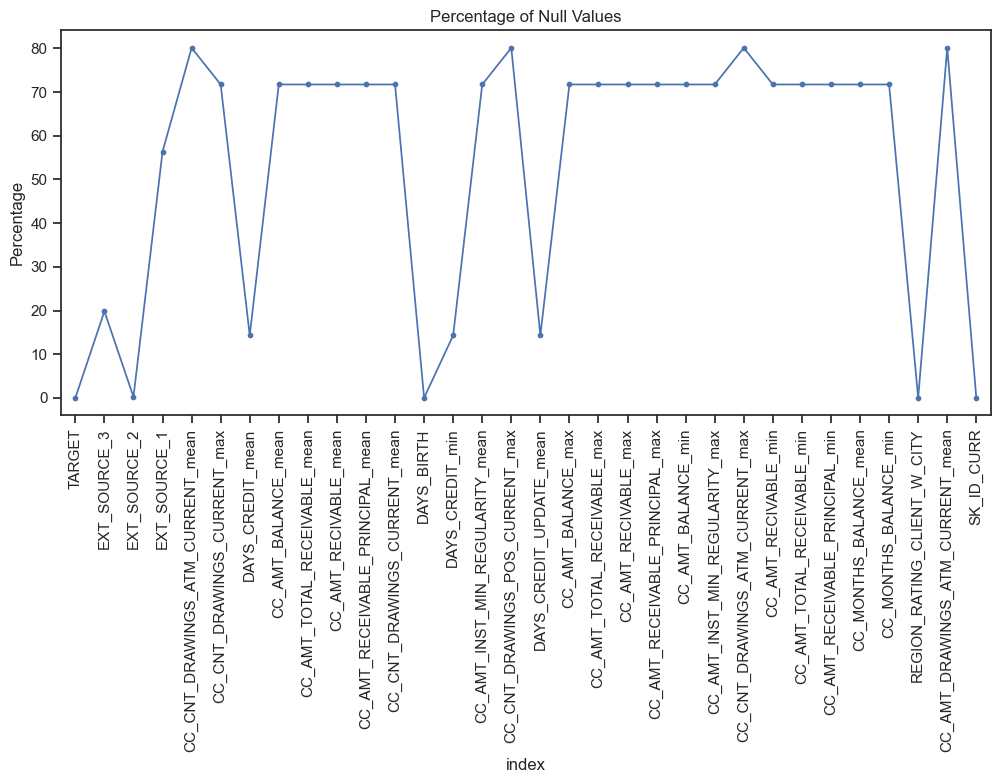

In [99]:
missing_plot(train_data)
# will leave it since we are going to use LGBOOST


In [101]:
days_based_cat = [i for i in train_data.columns if 'DAYS' in i]
months_based_cat = [i for i in train_data.columns if 'MONTHS' in i]

In [105]:
for i in days_based_cat + months_based_cat:
    train_data[i].fillna(0,inplace=True)
    test_data[i].fillna(0,inplace=True)
    train_data[i] = abs(train_data[i]).astype(int)
    test_data[i] = abs(test_data[i]).astype(int)

In [107]:
for feat in days_based_cat:
    test_data[feat] = pd.cut(test_data[feat], range(0, train_data[feat].max() + 1, 365), labels=[str(i) for i in range(0, train_data[feat].max() // 365)])
    train_data[feat] = pd.cut(train_data[feat], range(0, train_data[feat].max() + 1, 365), labels=[str(i) for i in range(0, train_data[feat].max() // 365)])
    train_data.rename(columns={feat: feat.replace('DAYS', 'YEARS')}, inplace=True)
    test_data.rename(columns={feat: feat.replace('DAYS', 'YEARS')}, inplace=True)

In [109]:
for feat in months_based_cat:
    test_data[feat] = pd.cut(test_data[feat], range(0, train_data[feat].max()+1, 12), labels=[str(i) for i in range(0, train_data[feat].max() // 12)])
    train_data[feat] = pd.cut(train_data[feat], range(0, train_data[feat].max()+1, 12), labels=[str(i) for i in range(0, train_data[feat].max() // 12)])
    train_data.rename(columns={feat: feat.replace('MONTHS', 'YEARS')}, inplace=True)
    test_data.rename(columns={feat: feat.replace('MONTHS', 'YEARS')}, inplace=True)

In [111]:
categorical_features = get_categorical_features(train_data)
len(categorical_features)

6

In [113]:
numerical_features = get_numerical_features(train_data.drop('SK_ID_CURR', axis=1))
len(numerical_features)


23

In [115]:
categorical_features

['TARGET',
 'YEARS_CREDIT_mean',
 'YEARS_CREDIT_min',
 'CC_YEARS_BALANCE_mean',
 'CC_YEARS_BALANCE_min',
 'REGION_RATING_CLIENT_W_CITY']

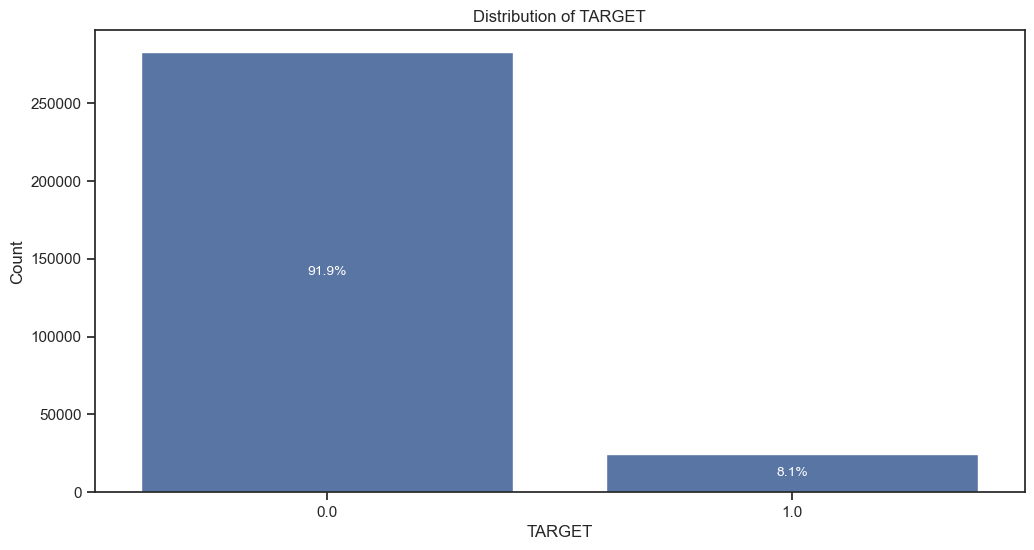

In [117]:
# TARGET (huge imbalance)
bar_plot(train_data, column='TARGET', size=(12,6))


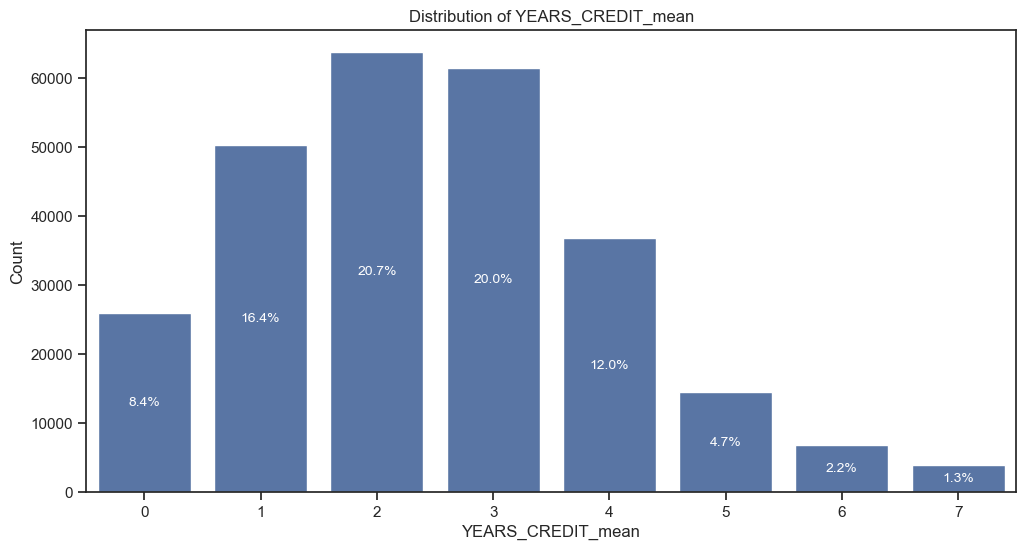

In [119]:
bar_plot(train_data, column='YEARS_CREDIT_mean', size=(12,6))

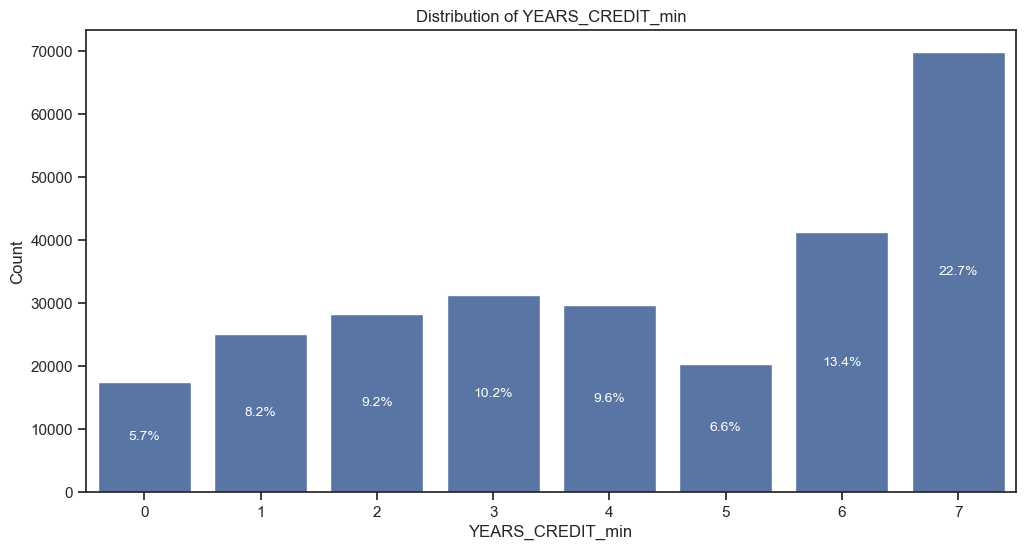

In [121]:
# YEARS_CREDIT_min
bar_plot(train_data, column='YEARS_CREDIT_min', size=(12,6))

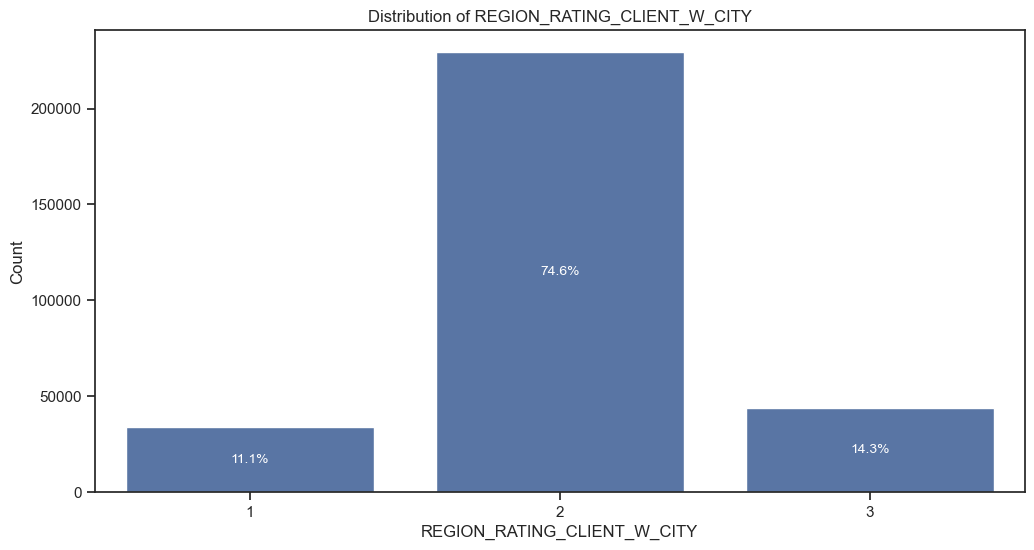

In [123]:
# REGION_RATING_CLIENT_W_CITY
bar_plot(train_data, column='REGION_RATING_CLIENT_W_CITY', size=(12,6))

In [125]:
numerical_features

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'CC_CNT_DRAWINGS_ATM_CURRENT_mean',
 'CC_CNT_DRAWINGS_CURRENT_max',
 'CC_AMT_BALANCE_mean',
 'CC_AMT_TOTAL_RECEIVABLE_mean',
 'CC_AMT_RECIVABLE_mean',
 'CC_AMT_RECEIVABLE_PRINCIPAL_mean',
 'CC_CNT_DRAWINGS_CURRENT_mean',
 'CC_AMT_INST_MIN_REGULARITY_mean',
 'CC_CNT_DRAWINGS_POS_CURRENT_max',
 'CC_AMT_BALANCE_max',
 'CC_AMT_TOTAL_RECEIVABLE_max',
 'CC_AMT_RECIVABLE_max',
 'CC_AMT_RECEIVABLE_PRINCIPAL_max',
 'CC_AMT_BALANCE_min',
 'CC_AMT_INST_MIN_REGULARITY_max',
 'CC_CNT_DRAWINGS_ATM_CURRENT_max',
 'CC_AMT_RECIVABLE_min',
 'CC_AMT_TOTAL_RECEIVABLE_min',
 'CC_AMT_RECEIVABLE_PRINCIPAL_min',
 'CC_AMT_DRAWINGS_ATM_CURRENT_mean']

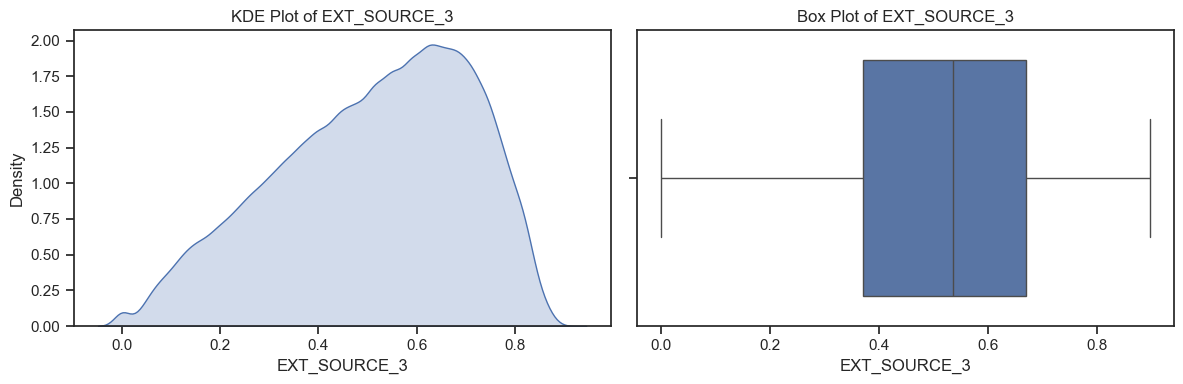

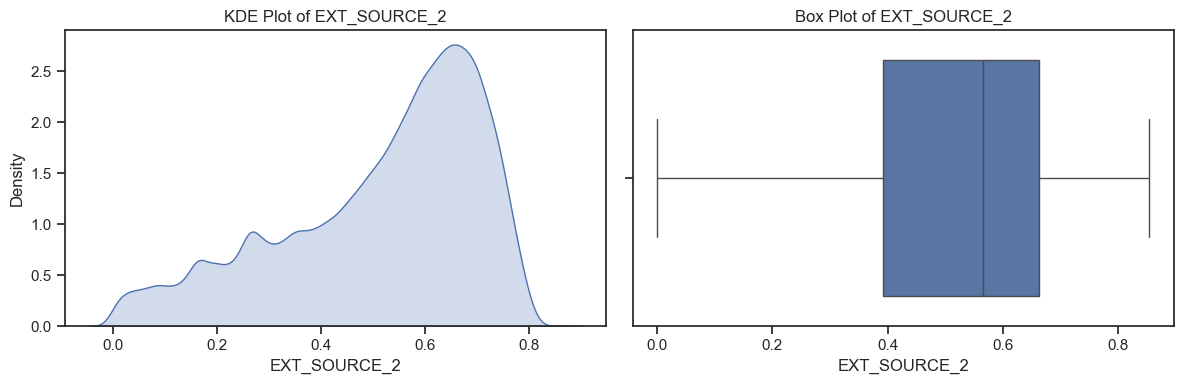

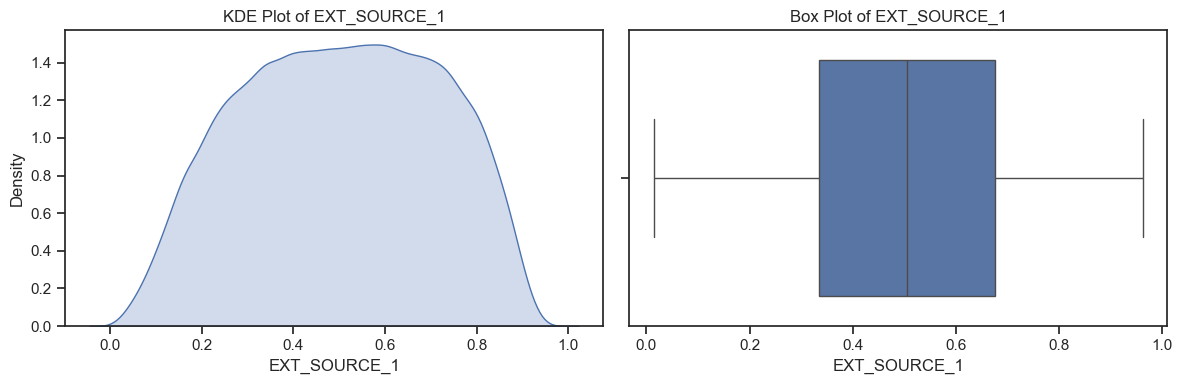

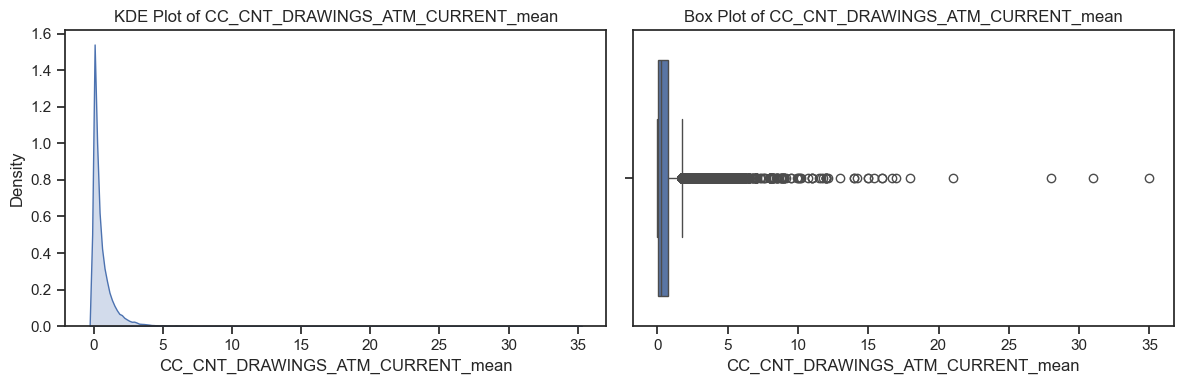

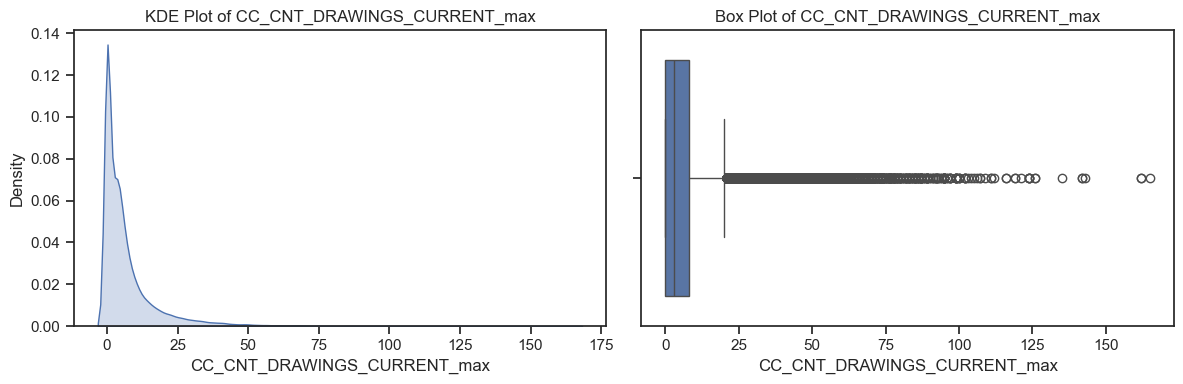

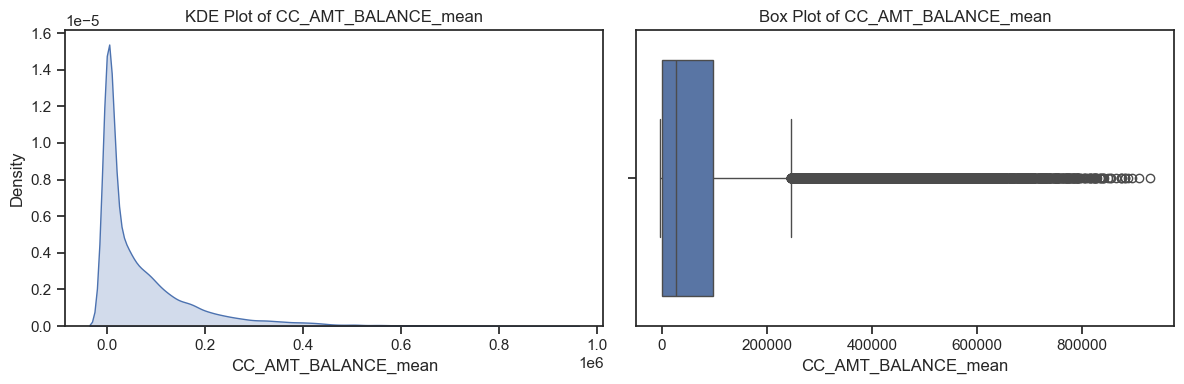

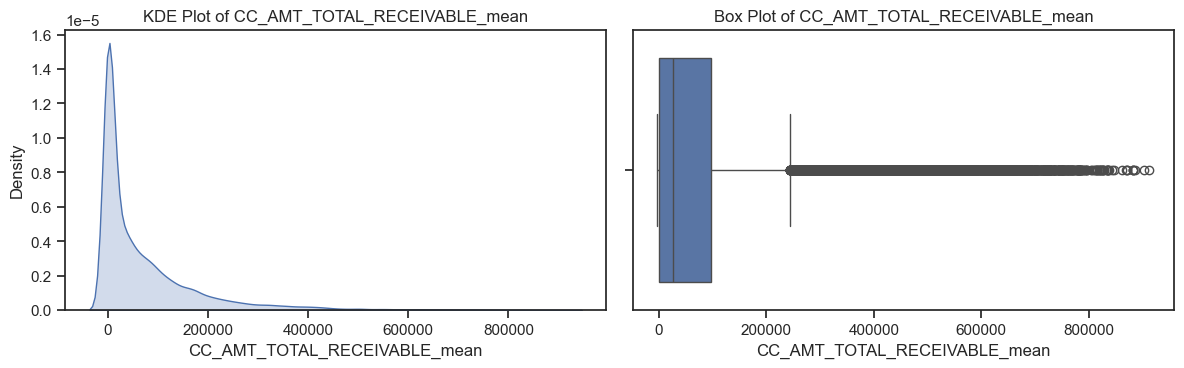

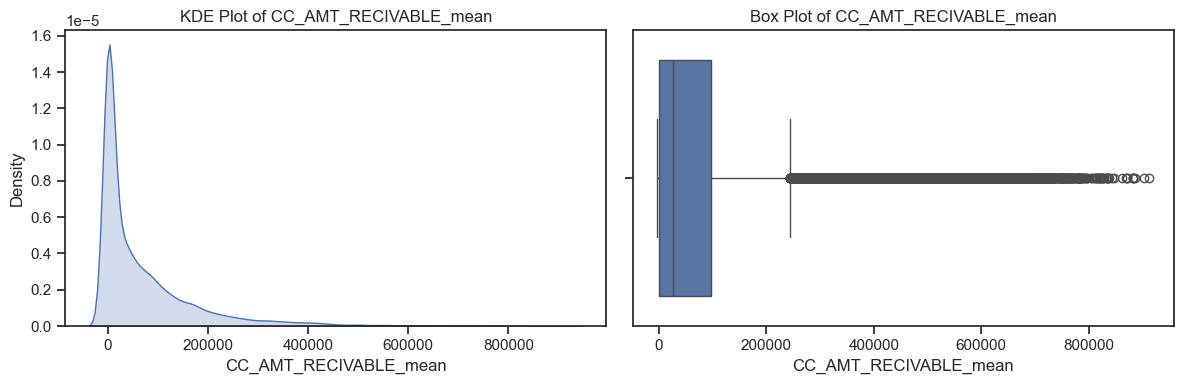

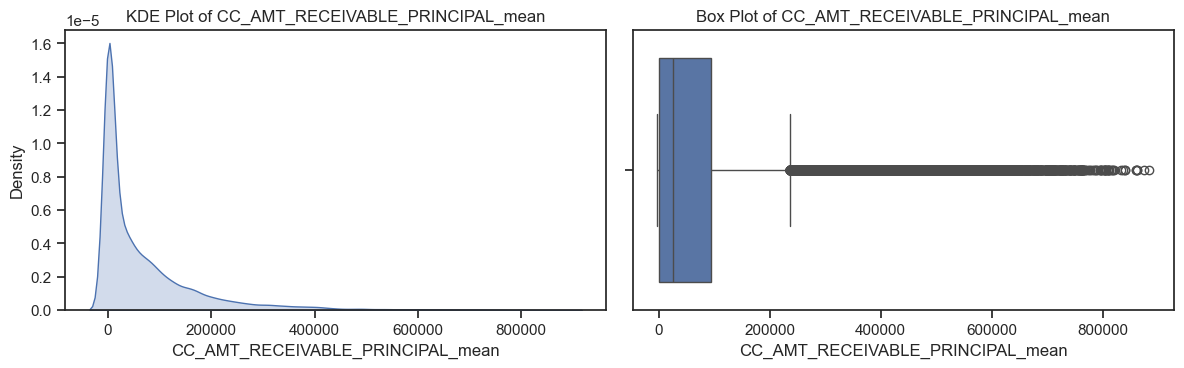

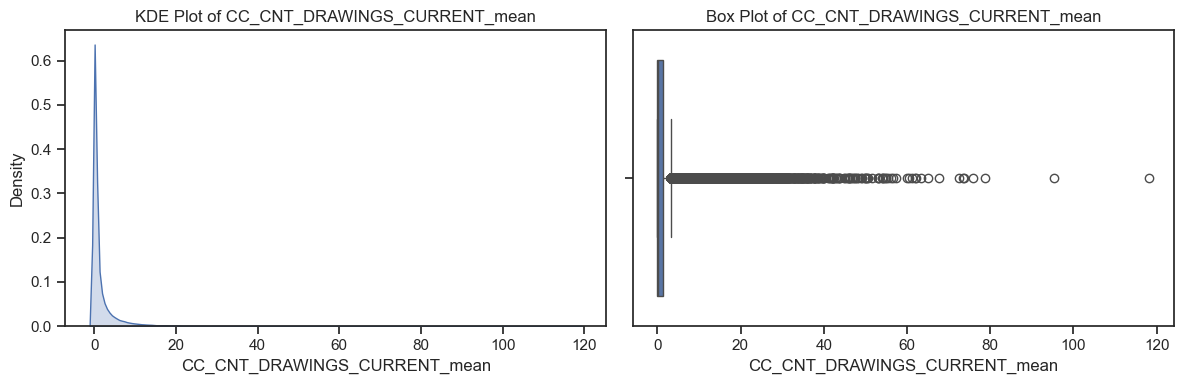

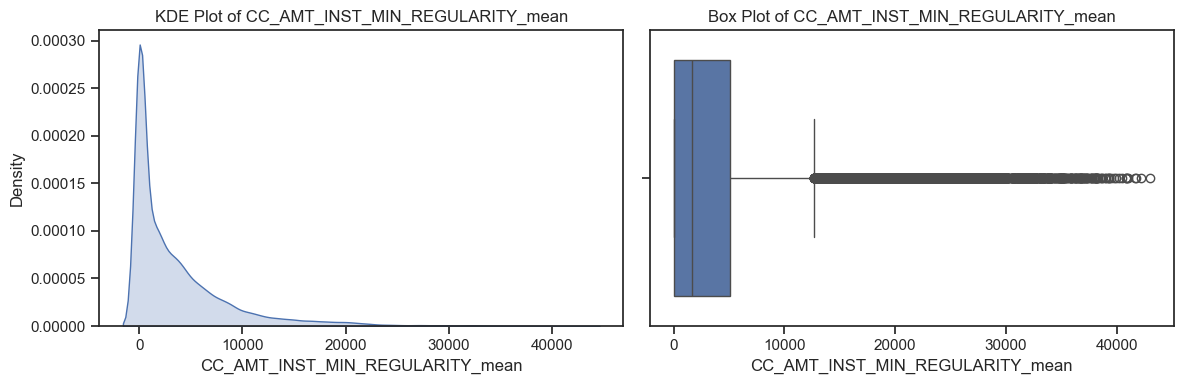

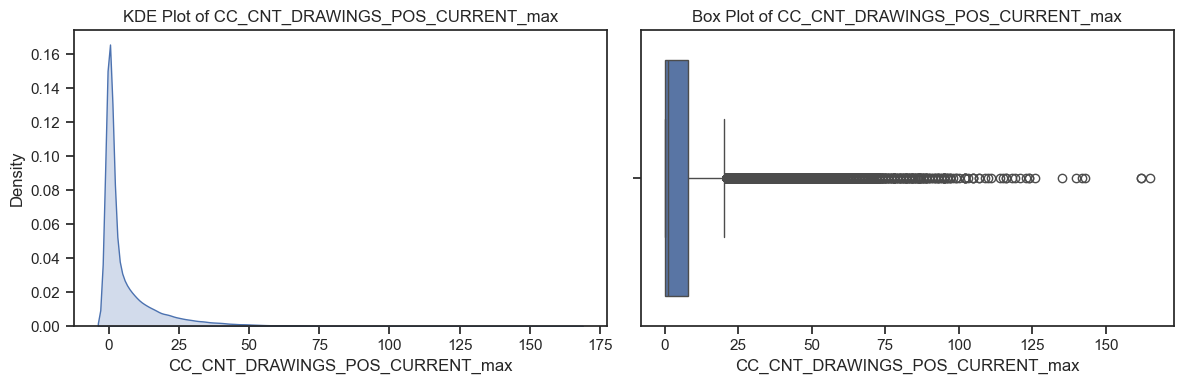

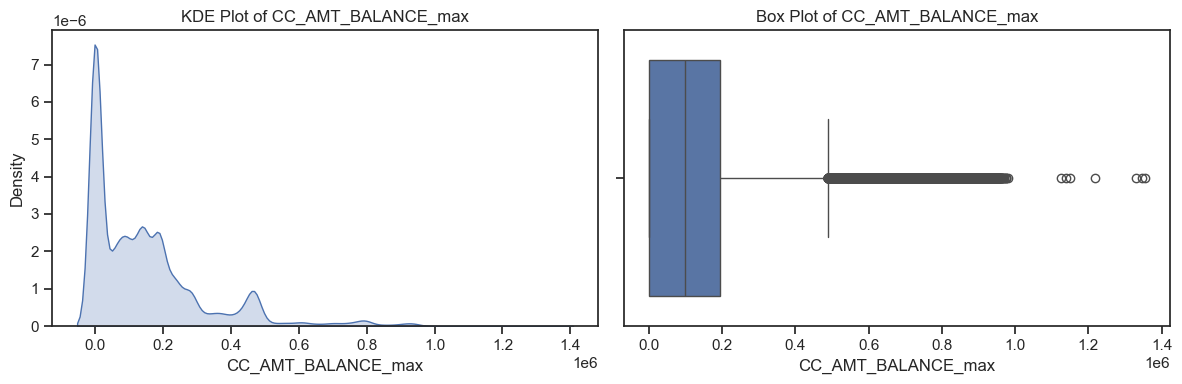

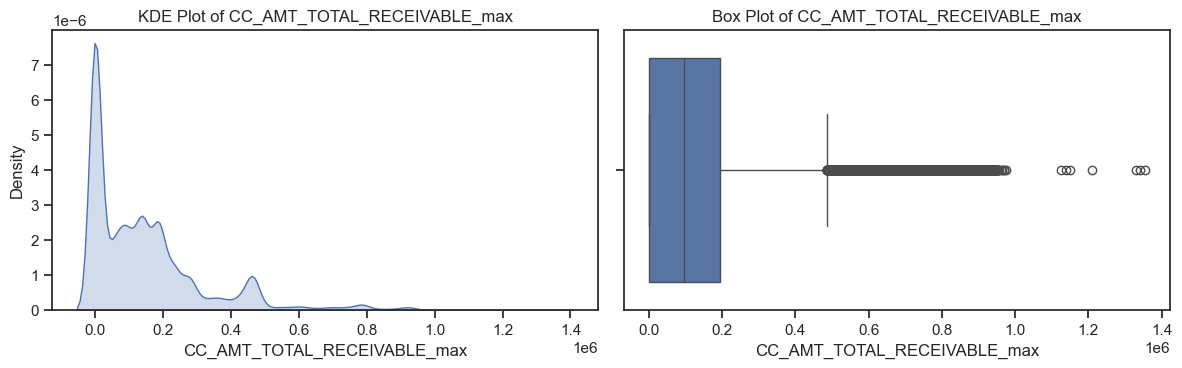

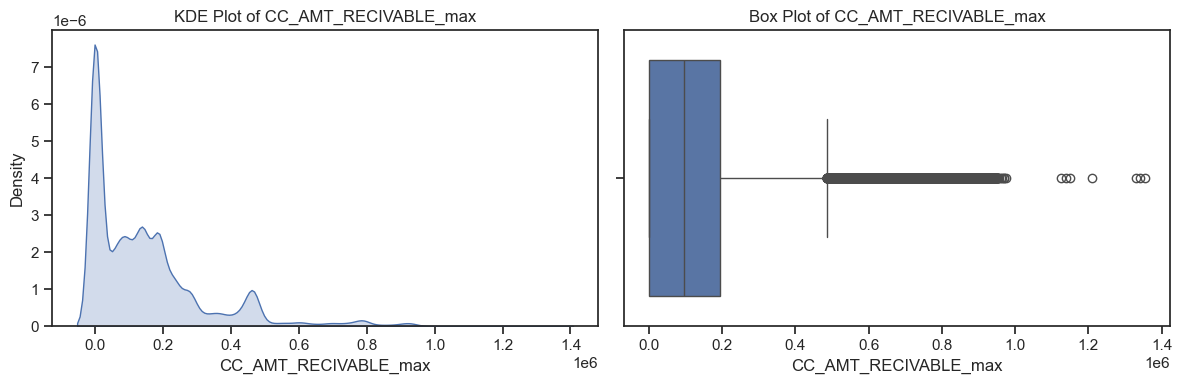

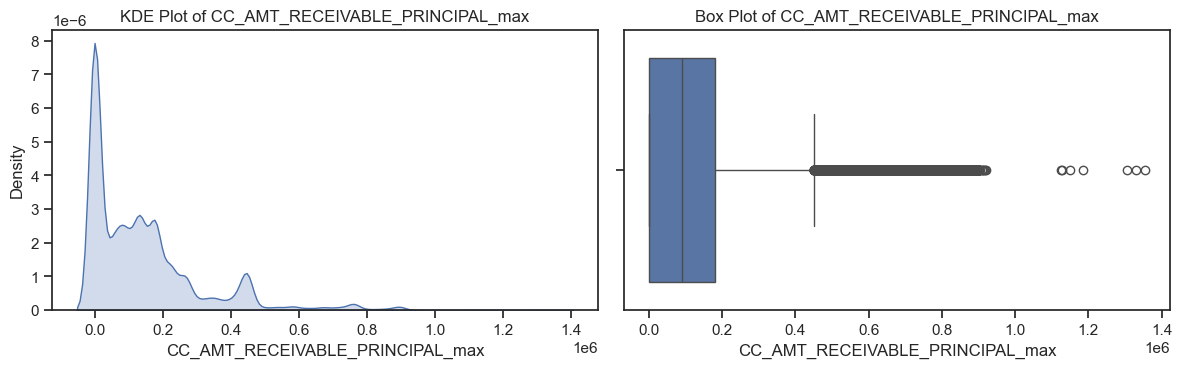

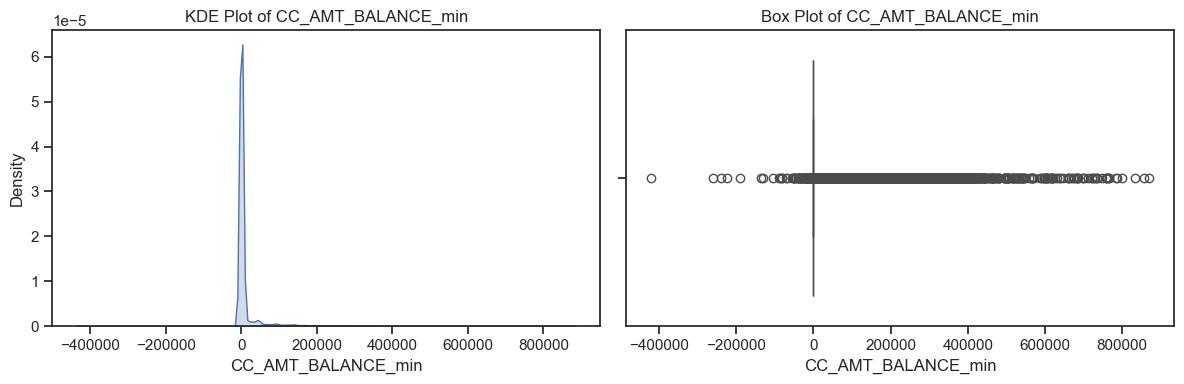

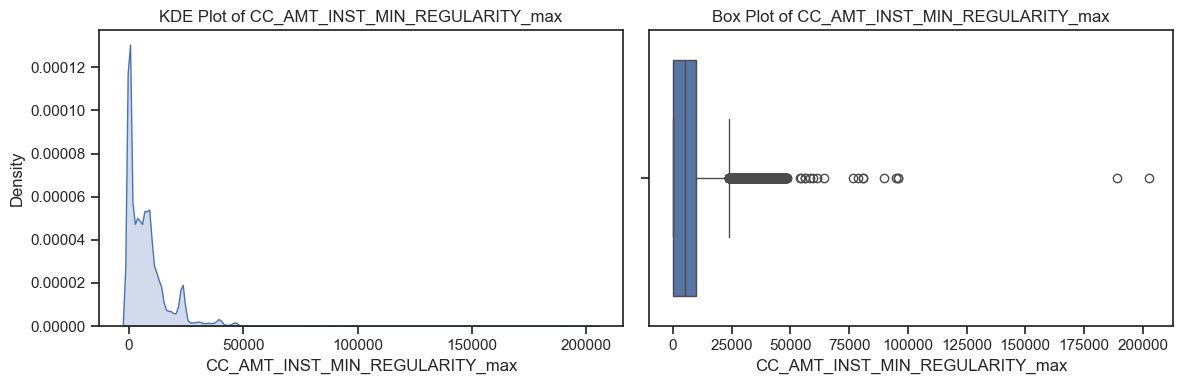

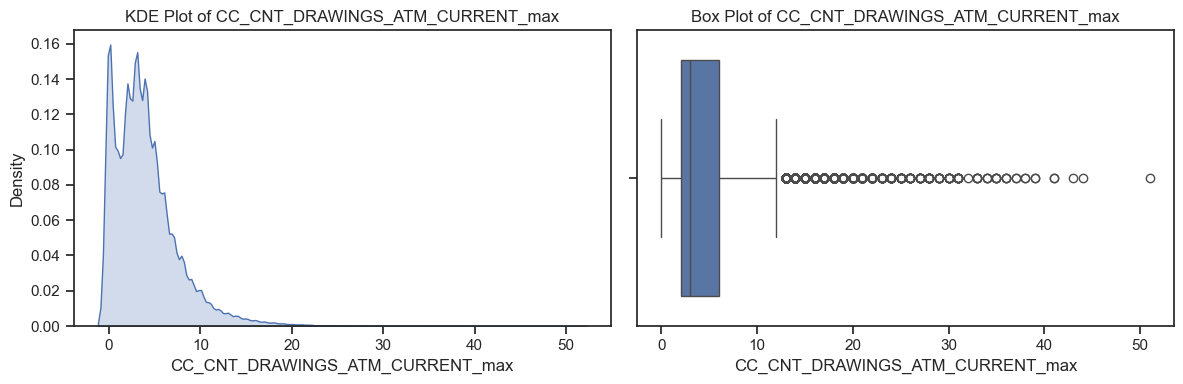

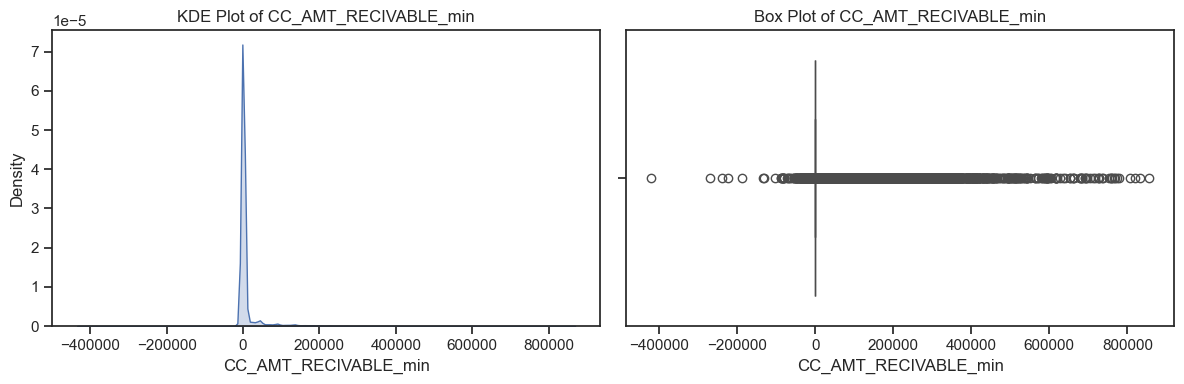

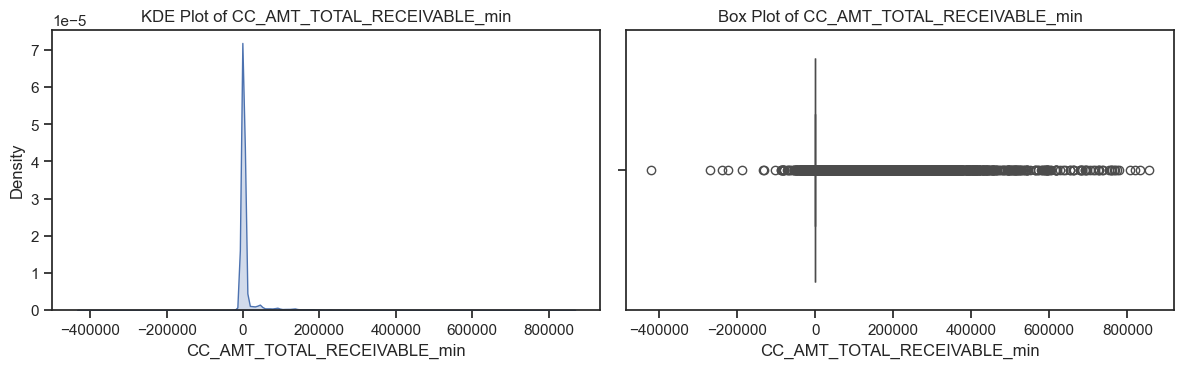

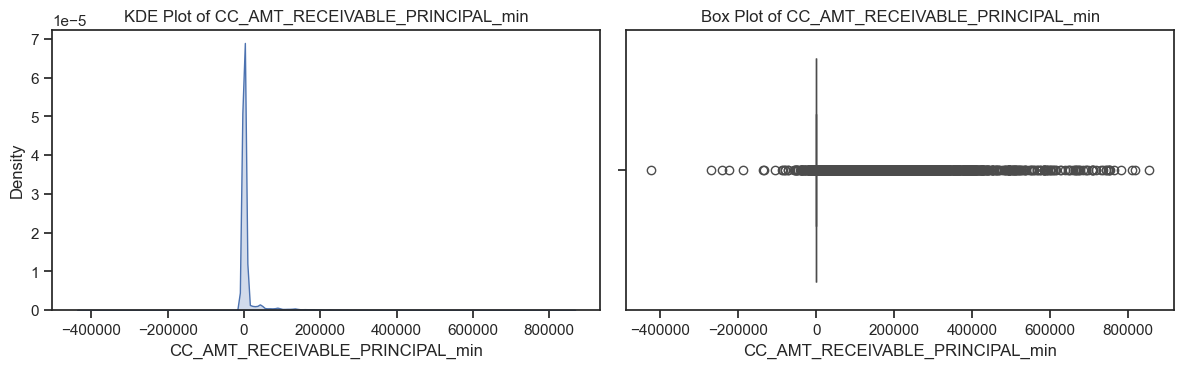

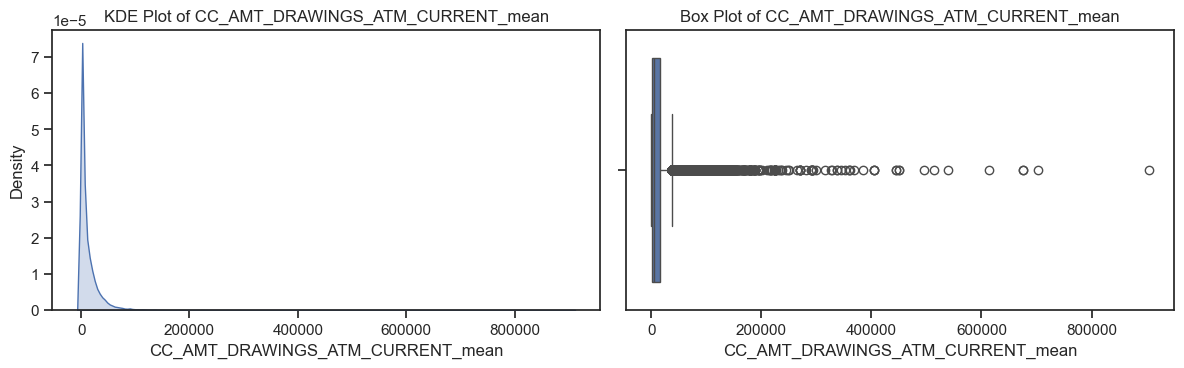

In [127]:
for column in numerical_features:
    plt.figure(figsize=(12, 4))  # Create a new figure for each feature

    # Subplot 1: KDE Plot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    sns.kdeplot(train_data[column], shade=True)
    plt.title(f'KDE Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

    # Subplot 2: Box Plot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    sns.boxplot(x=train_data[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot

In [129]:
temp_data = apply_log_transform(train_data.drop('SK_ID_CURR', axis=1))
temp_data['SK_ID_CURR'] = train_data['SK_ID_CURR']
train_data = temp_data.copy()

In [131]:
temp_data = apply_log_transform(test_data.drop('SK_ID_CURR', axis=1))
temp_data['SK_ID_CURR'] = test_data['SK_ID_CURR']
test_data = temp_data.copy()

In [133]:
for feat in numerical_features:
    train_data[feat] = outlier_cut(train_data[feat])
    test_data[feat] = outlier_cut(test_data[feat])

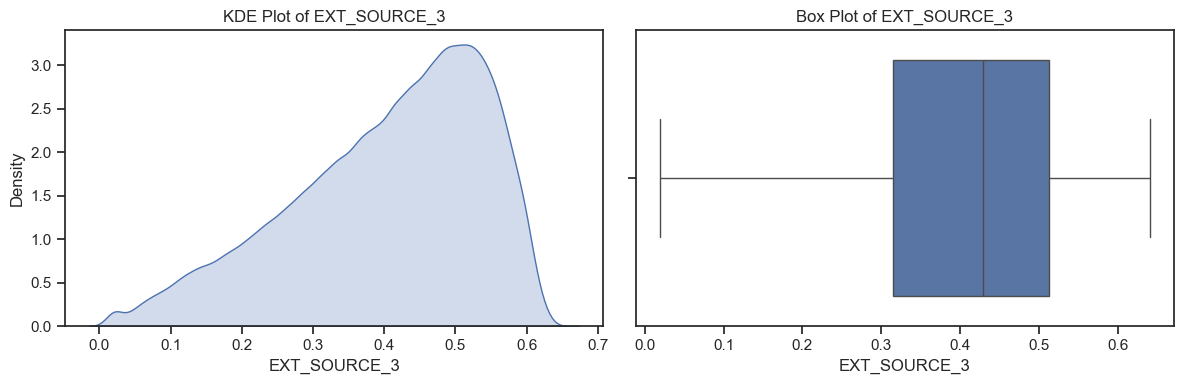

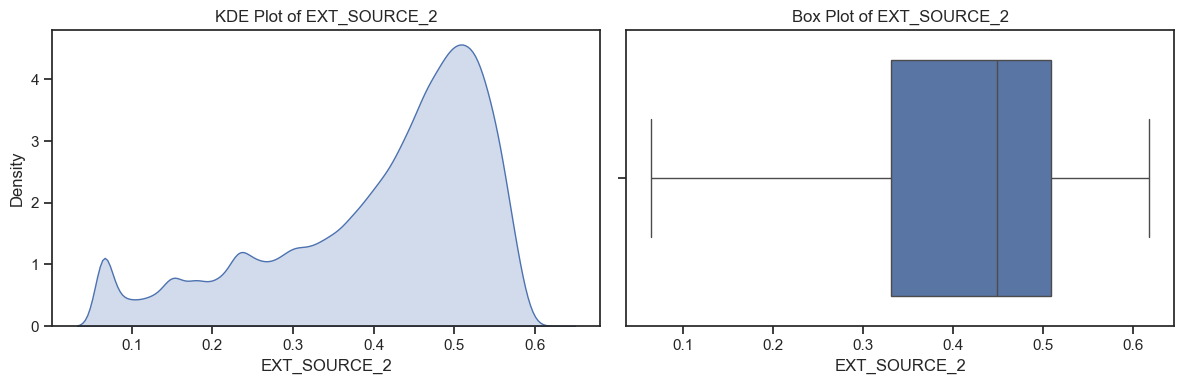

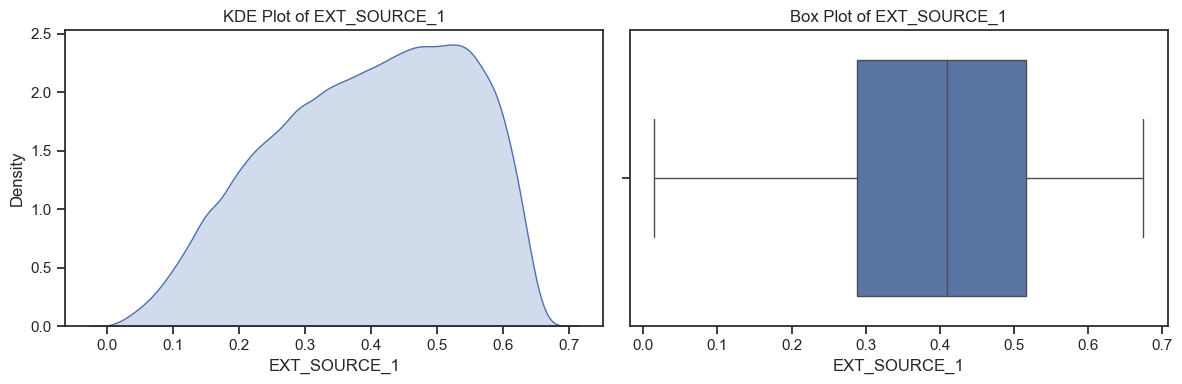

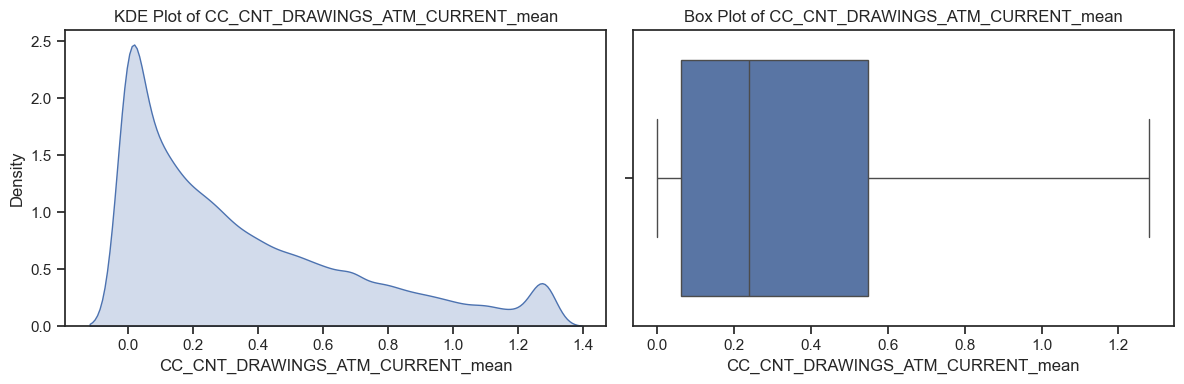

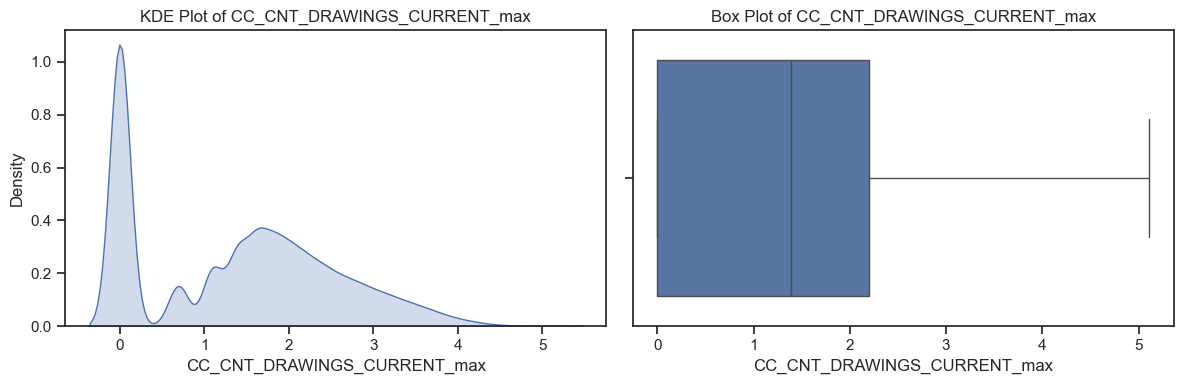

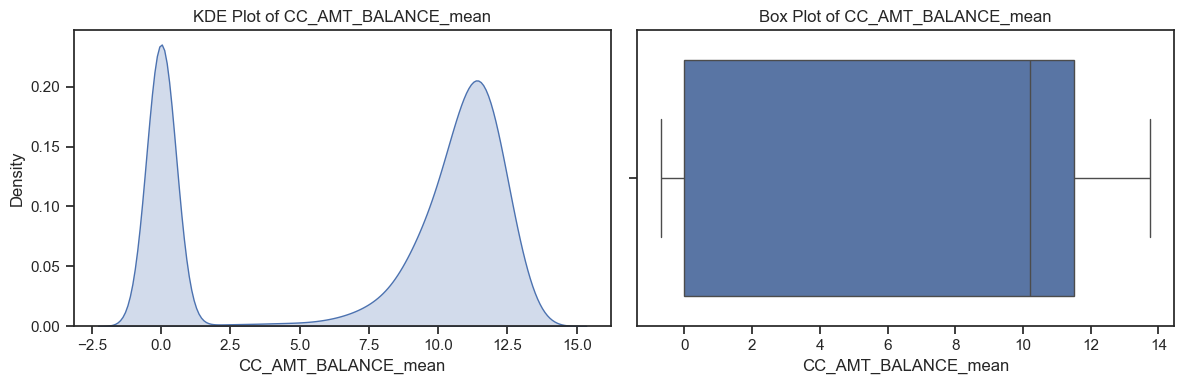

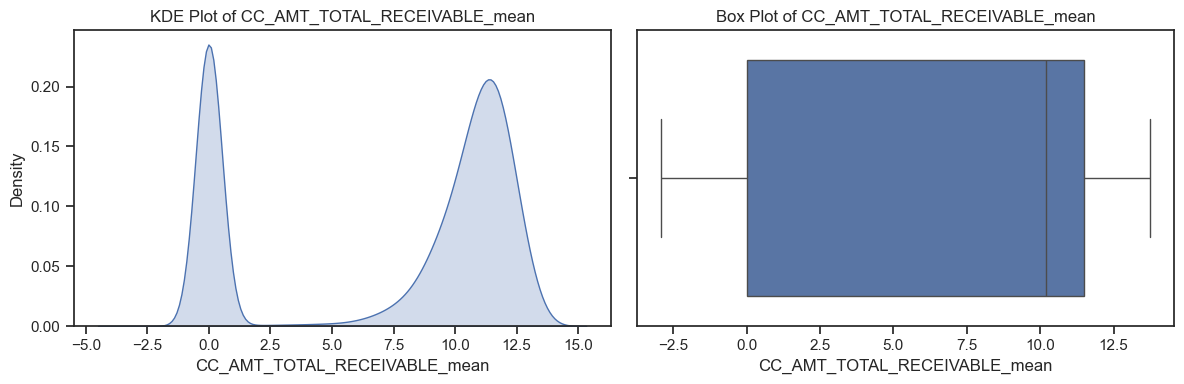

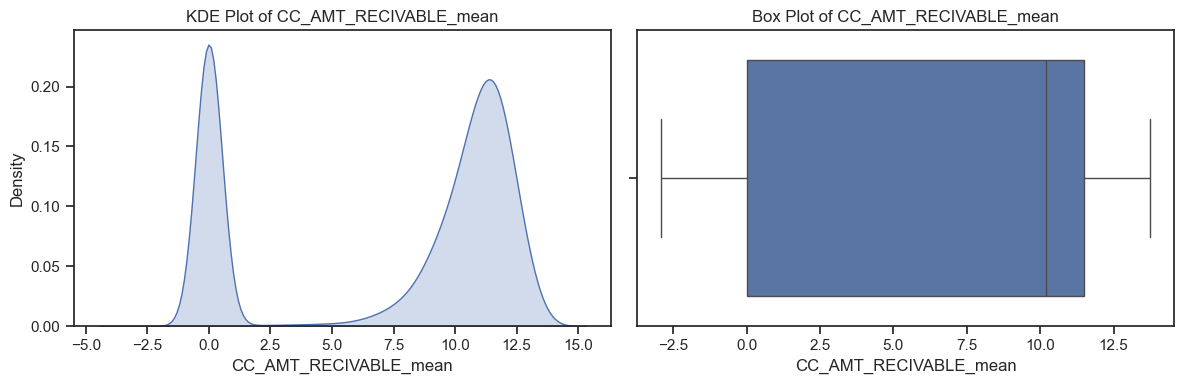

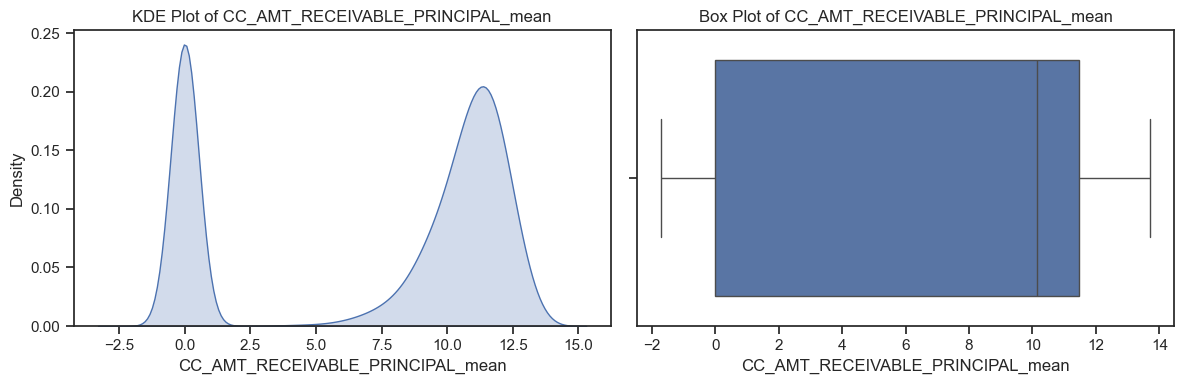

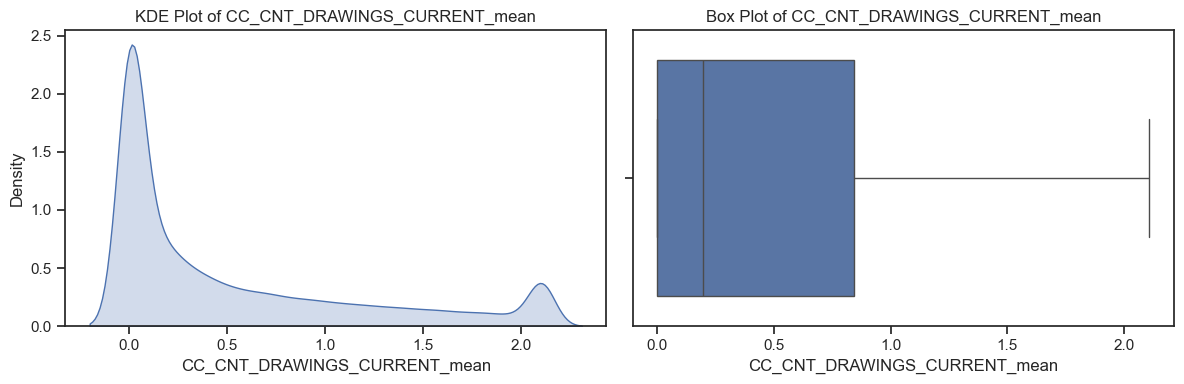

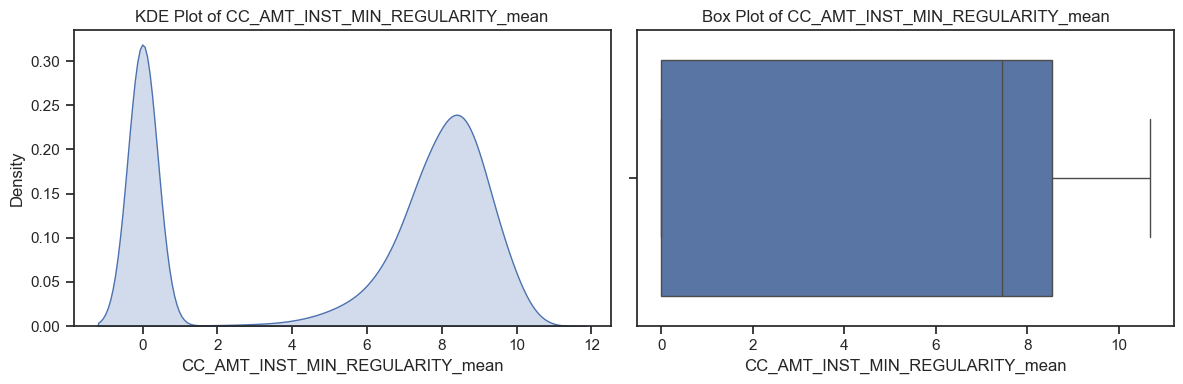

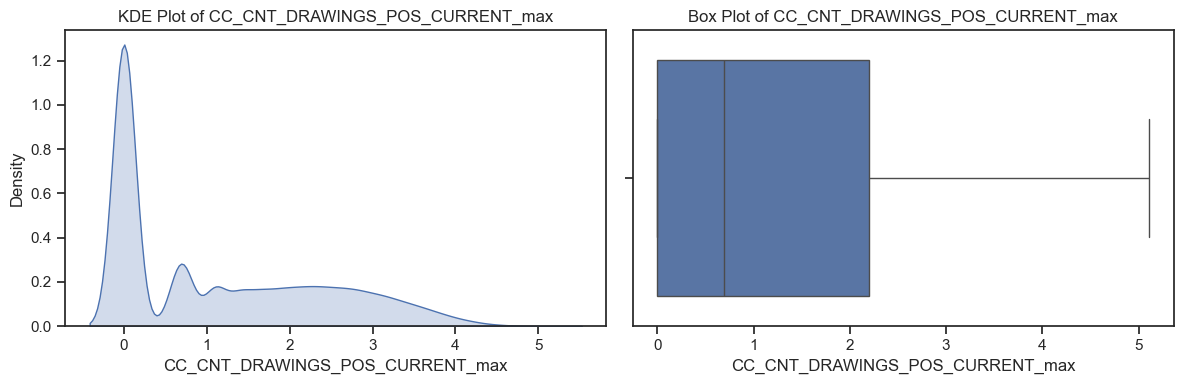

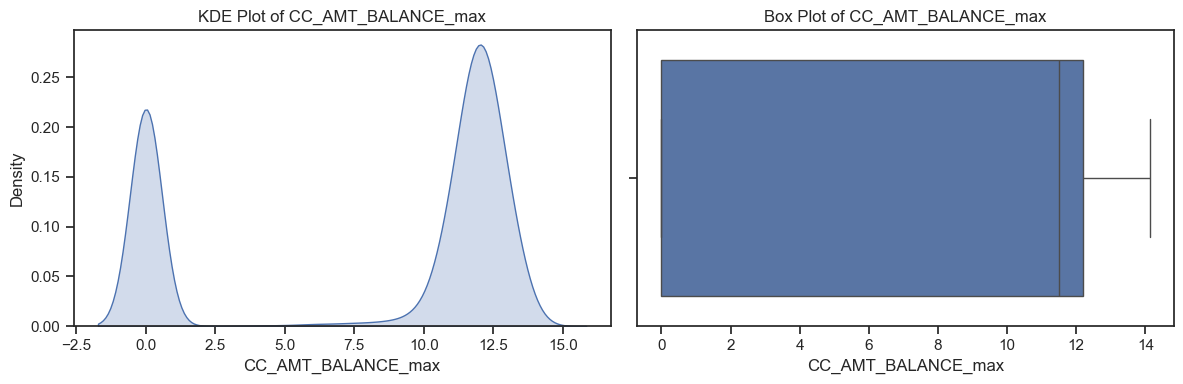

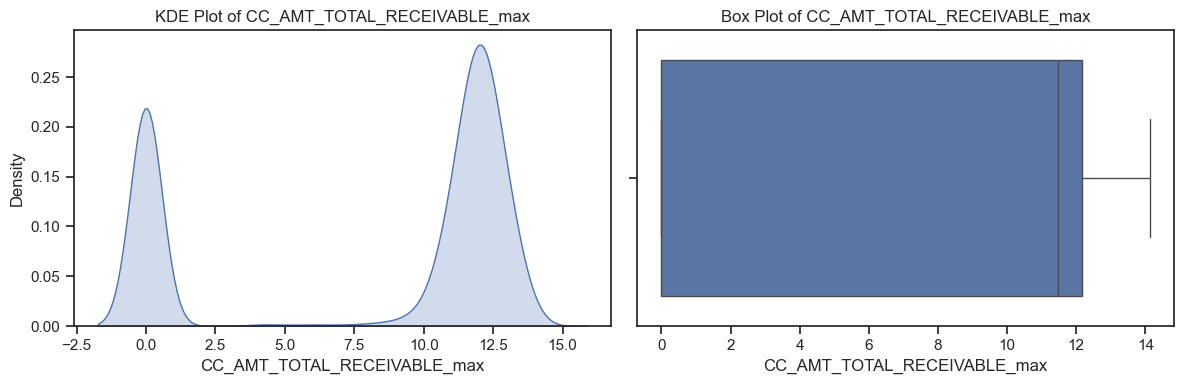

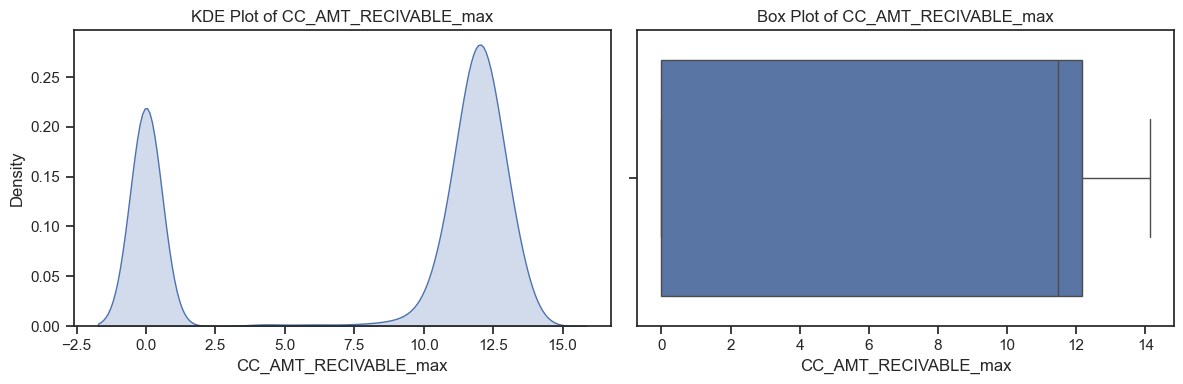

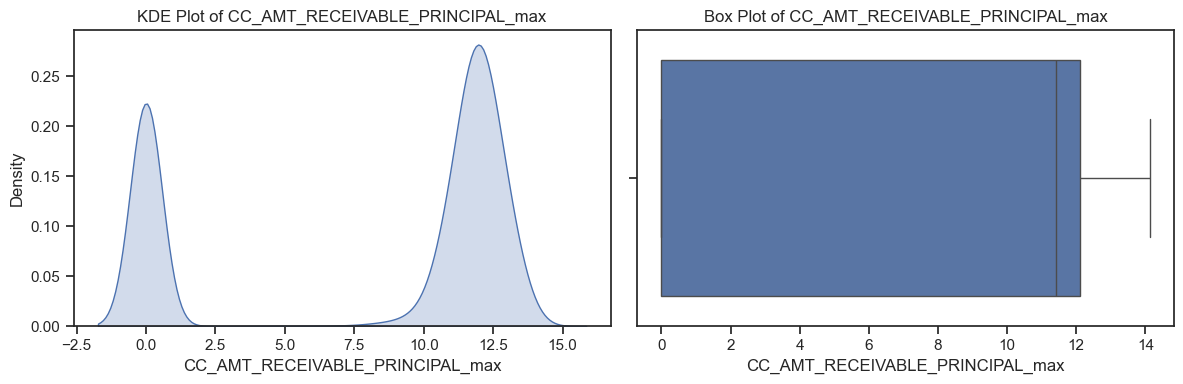

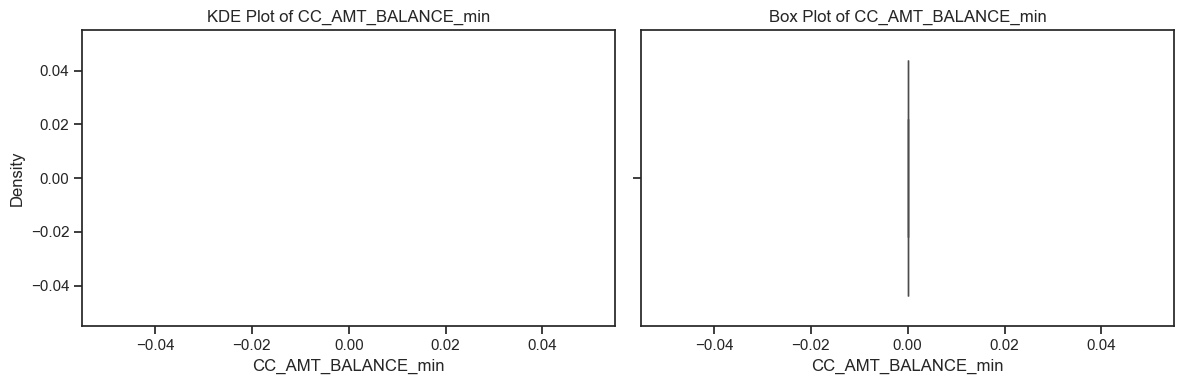

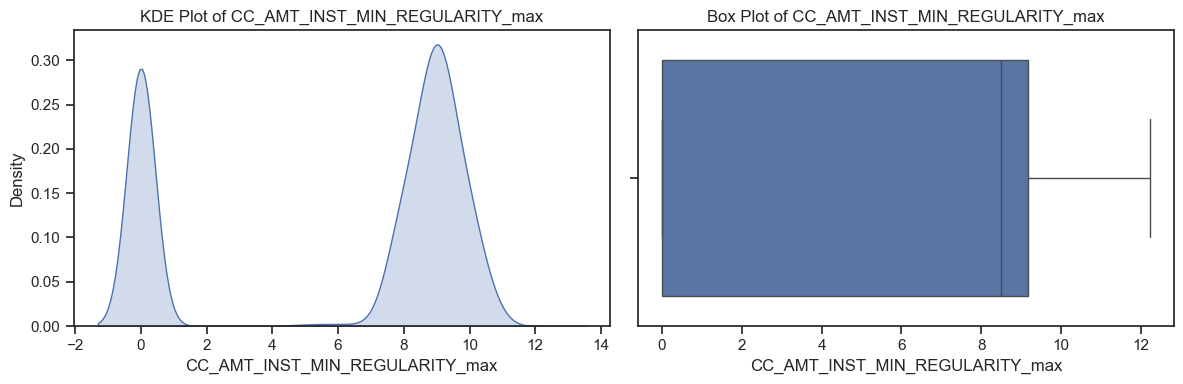

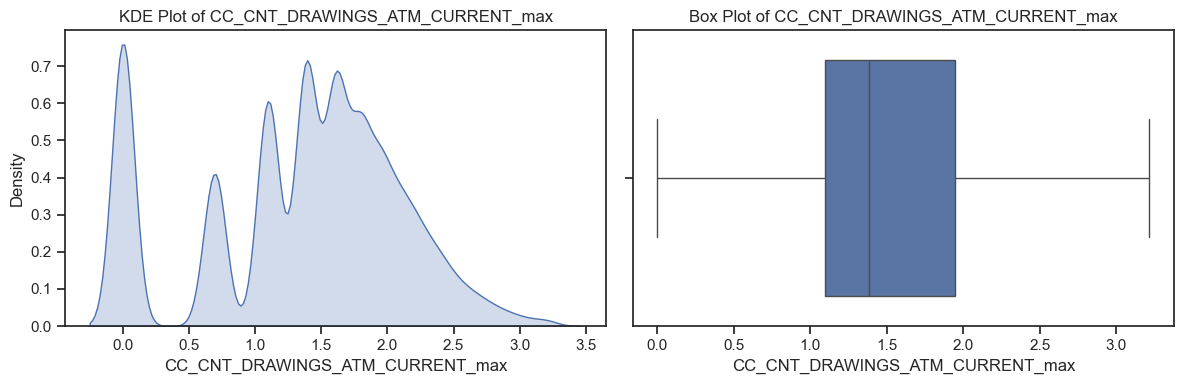

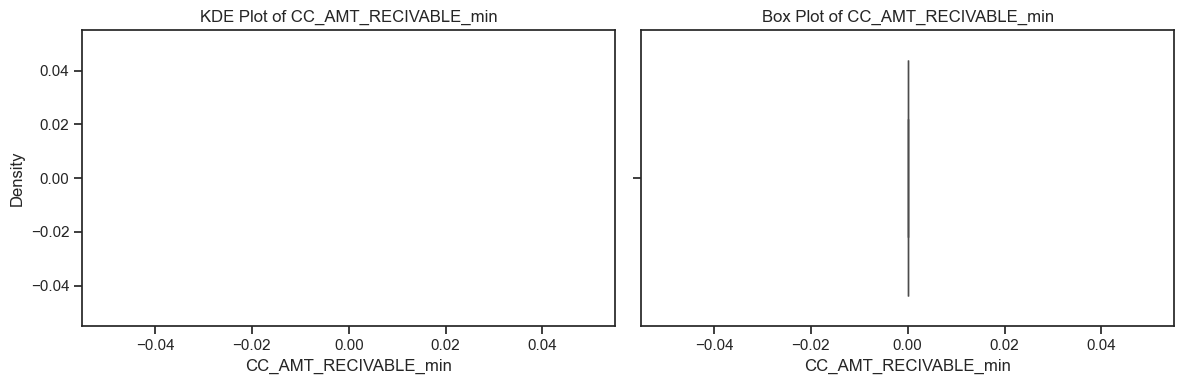

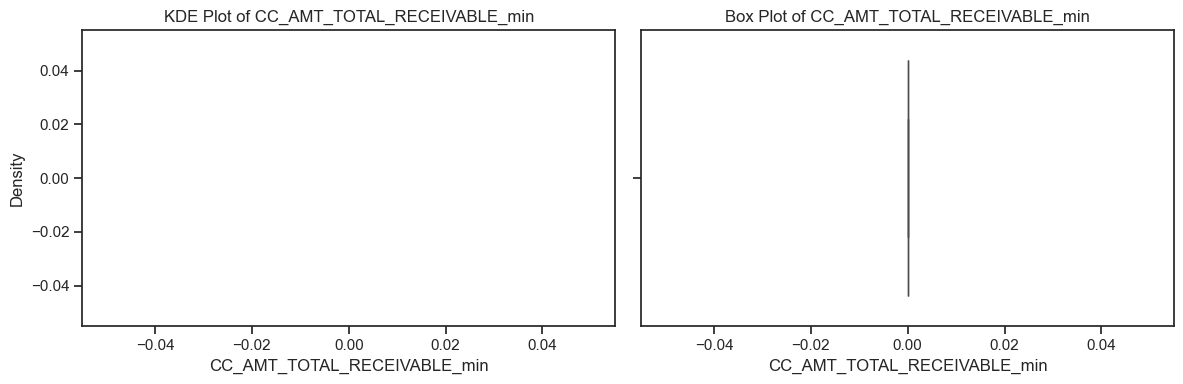

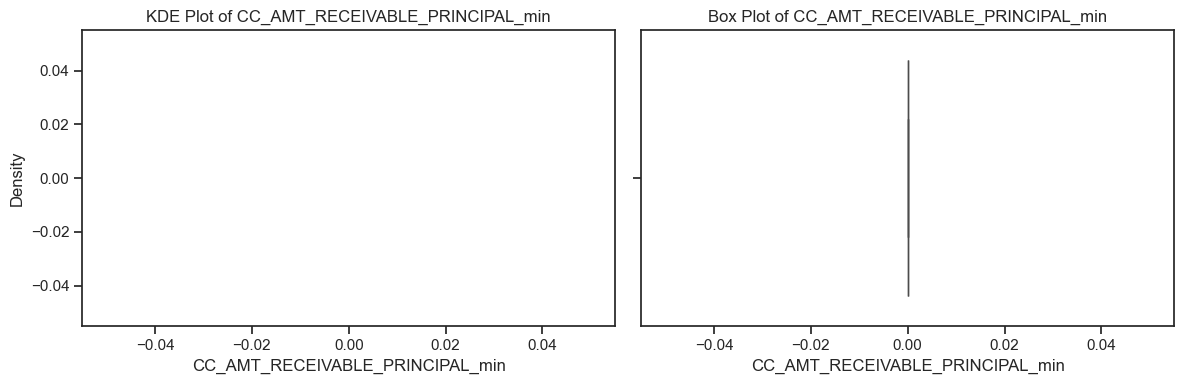

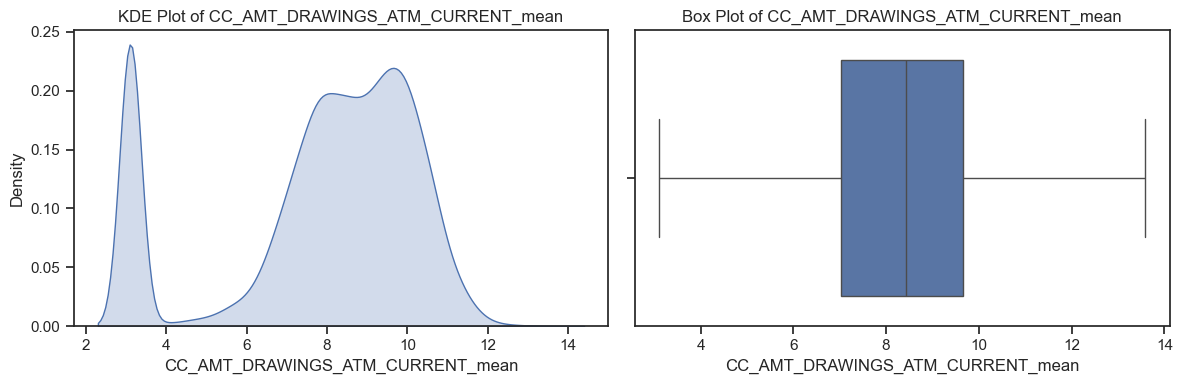

In [135]:
for column in numerical_features:
    plt.figure(figsize=(12, 4))  # Create a new figure for each feature

    # Subplot 1: KDE Plot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    sns.kdeplot(train_data[column], shade=True)
    plt.title(f'KDE Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

    # Subplot 2: Box Plot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    sns.boxplot(x=train_data[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot


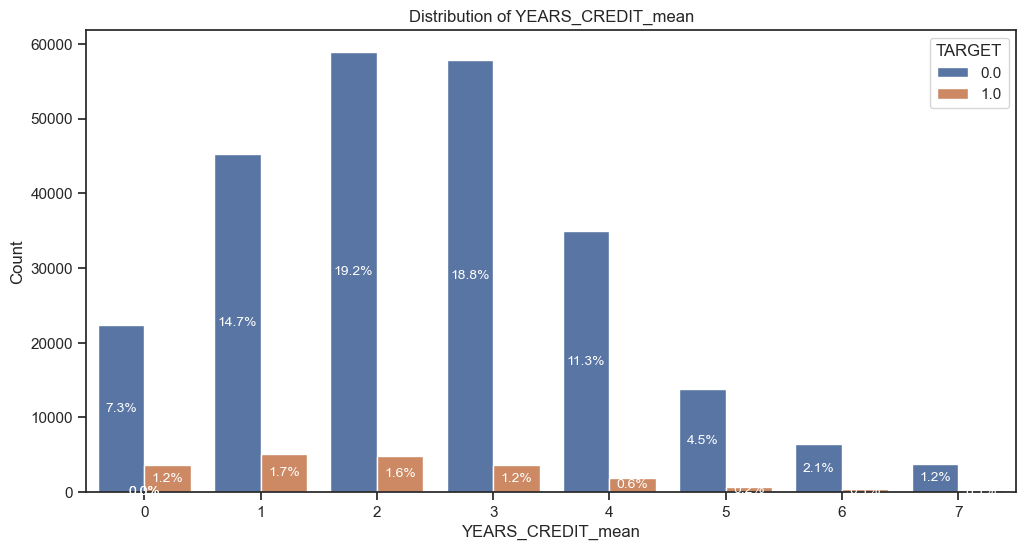

In [136]:
# YEARS_CREDIT_mean
bar_plot(train_data, column='YEARS_CREDIT_mean', hue='TARGET', size=(12,6))

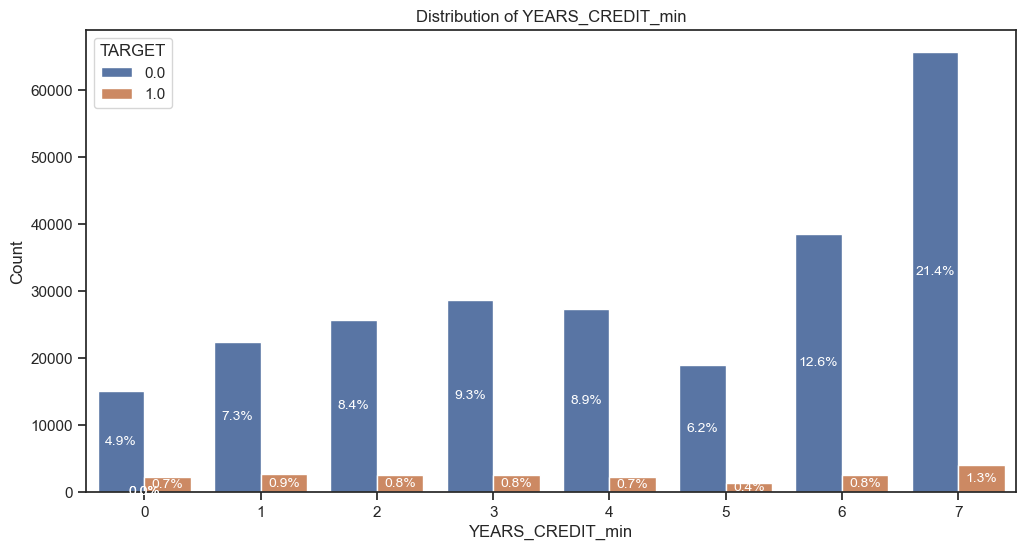

In [141]:
# YEARS_CREDIT_min
bar_plot(train_data, column='YEARS_CREDIT_min', hue='TARGET', size=(12,6))

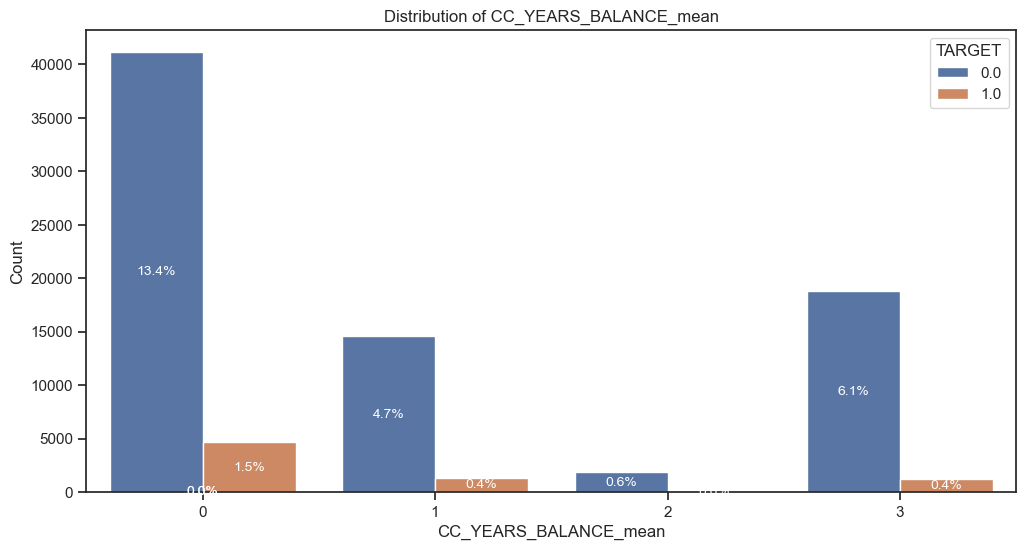

In [143]:
# CC_YEARS_BALANCE_mean
bar_plot(train_data, column='CC_YEARS_BALANCE_mean', hue='TARGET', size=(12,6))

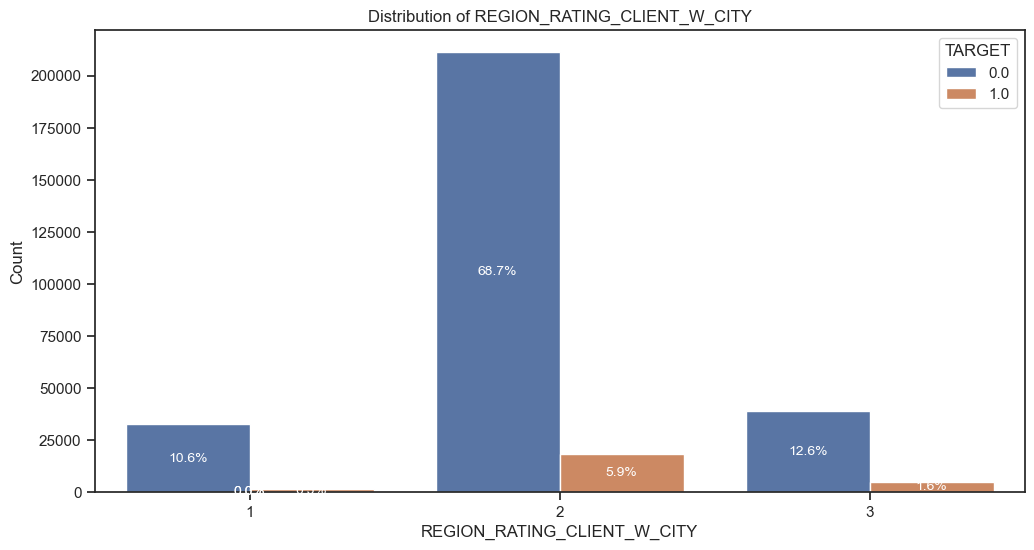

In [145]:
# REGION_RATING_CLIENT_W_CITY
bar_plot(train_data, column='REGION_RATING_CLIENT_W_CITY', hue='TARGET', size=(12,6))


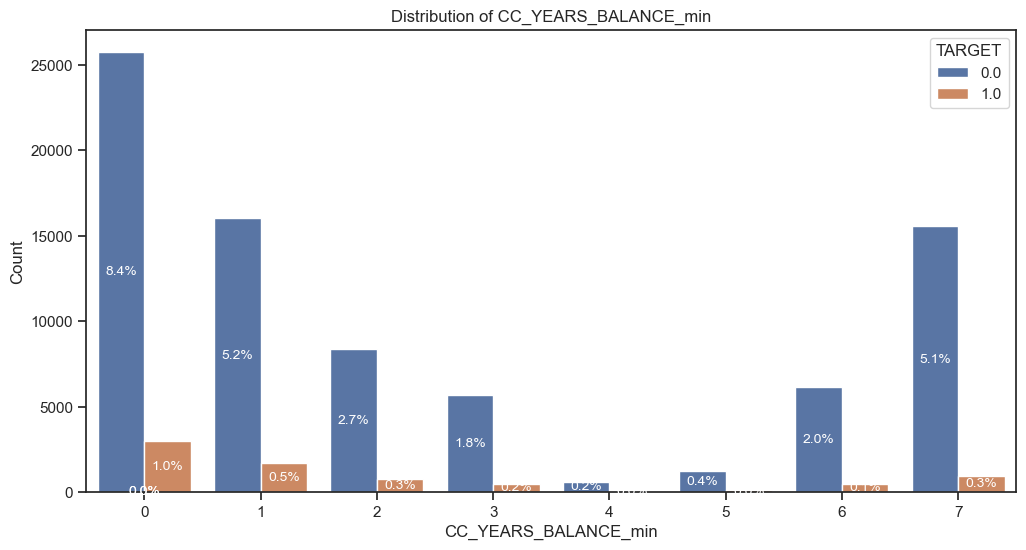

In [147]:
# CC_YEARS_BALANCE_min
bar_plot(train_data, column='CC_YEARS_BALANCE_min', hue='TARGET', size=(12,6))


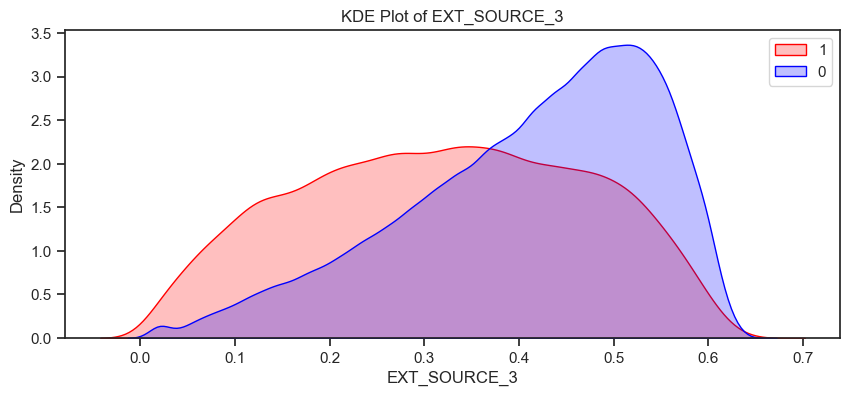

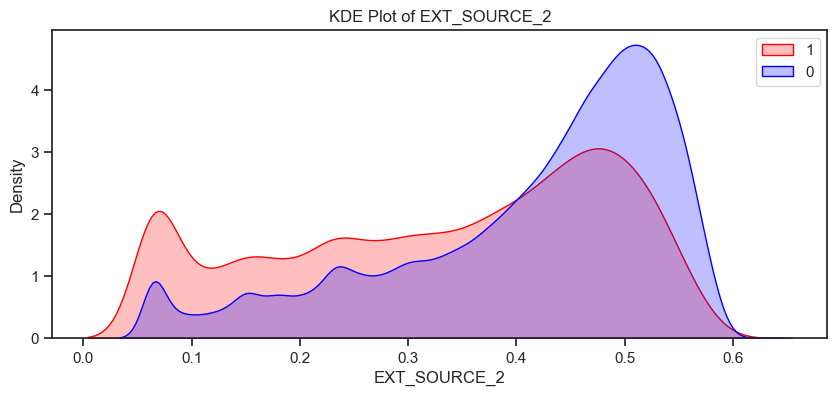

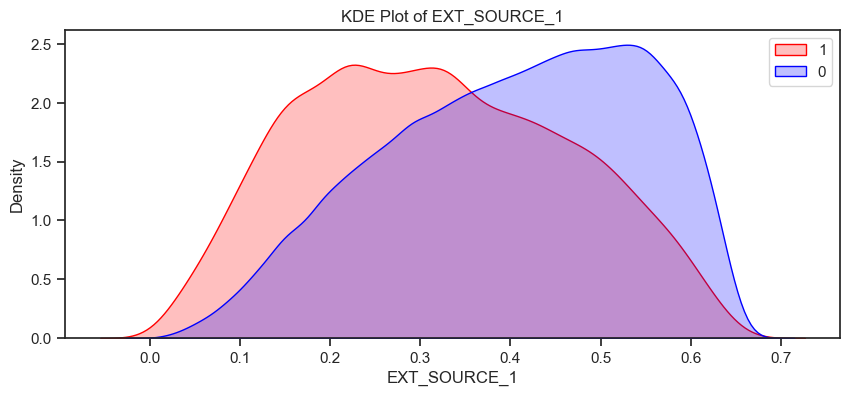

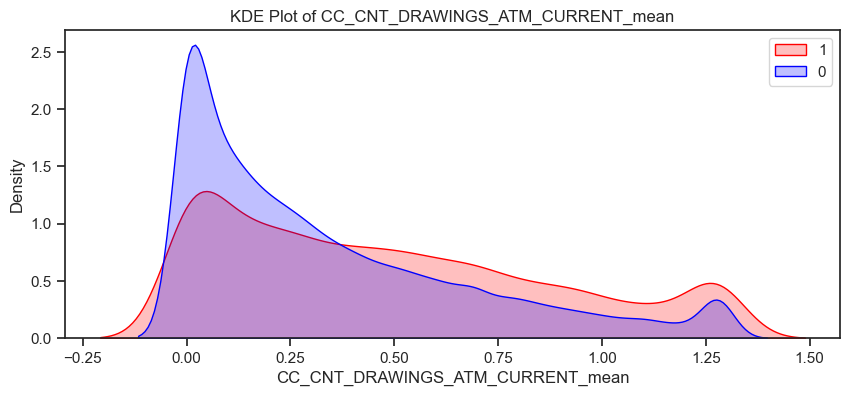

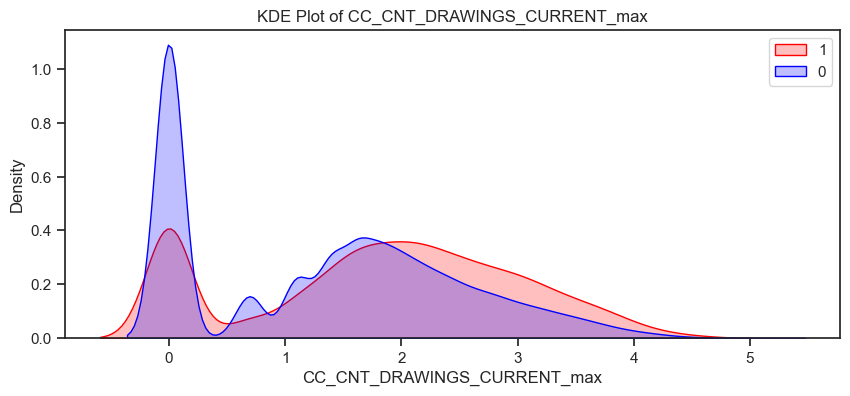

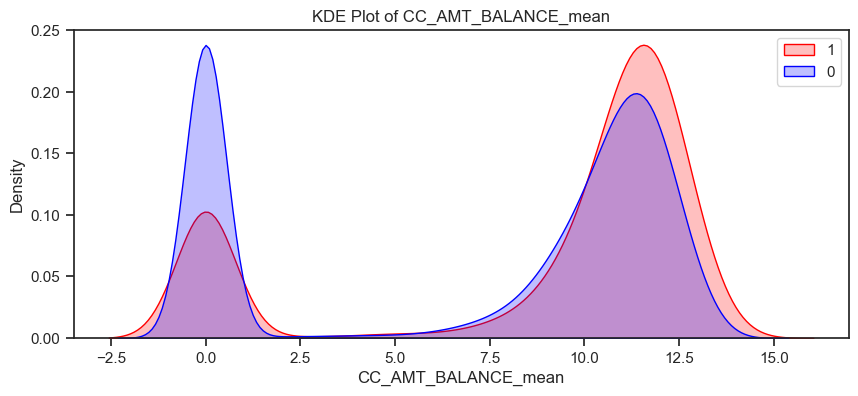

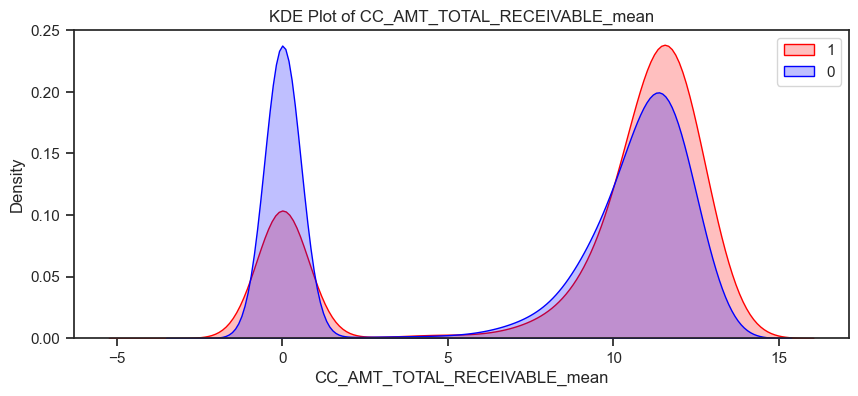

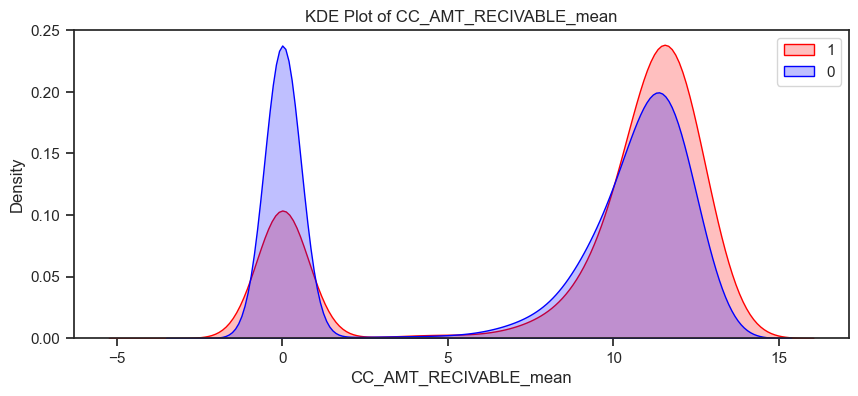

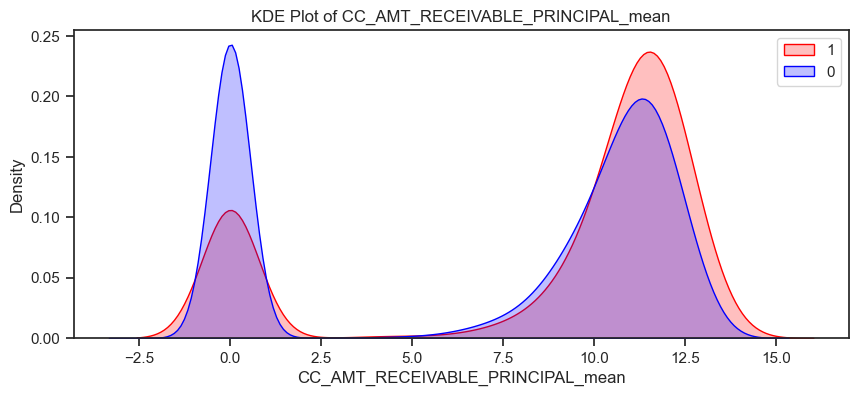

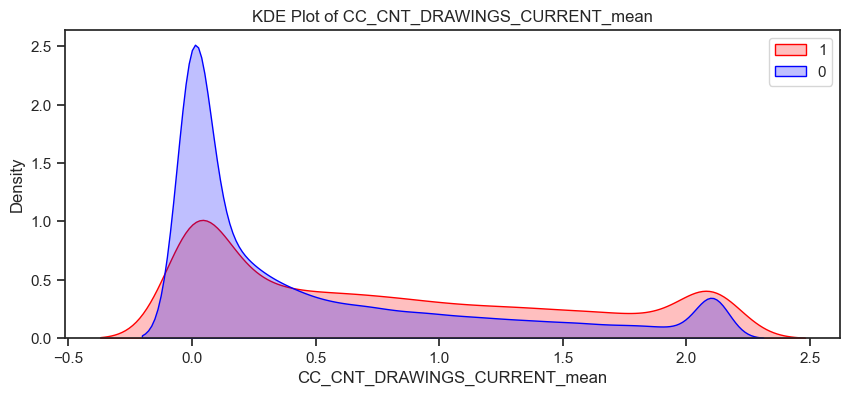

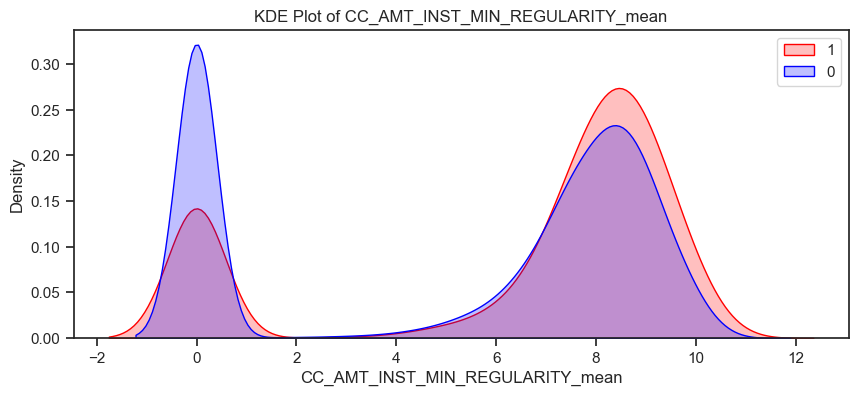

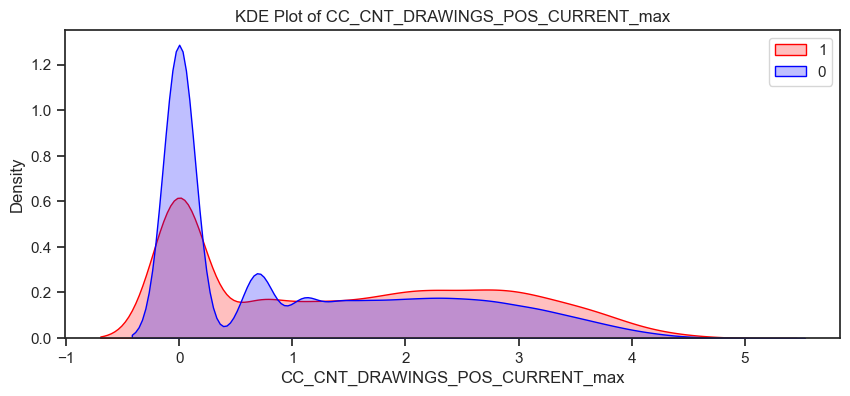

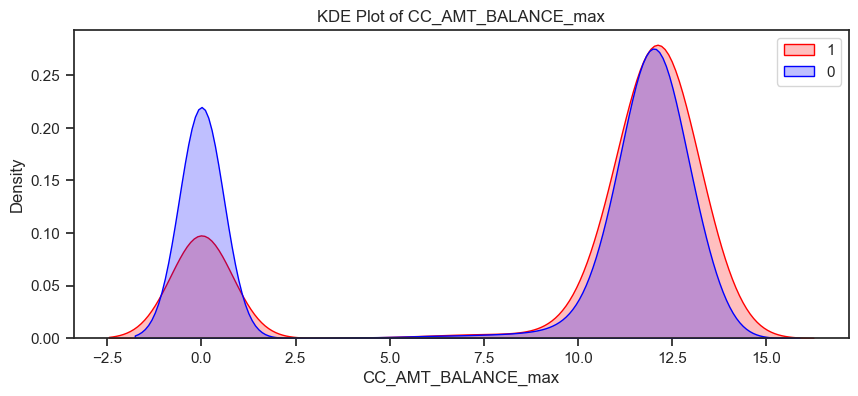

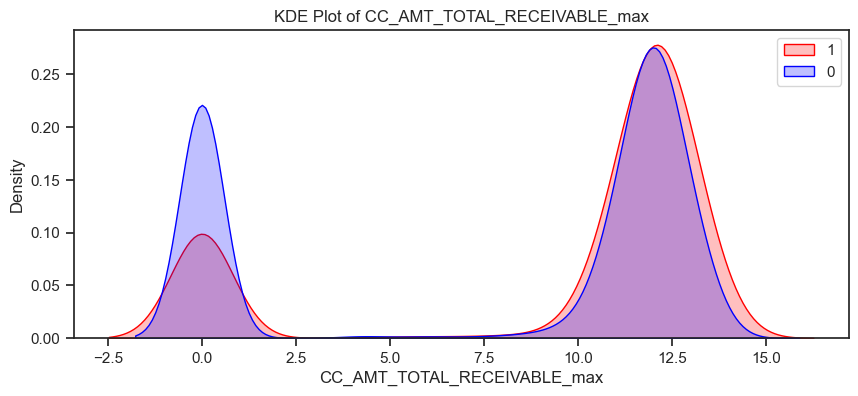

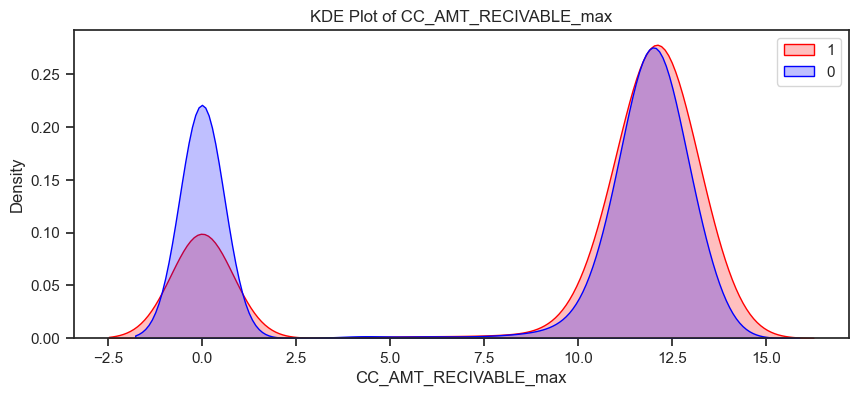

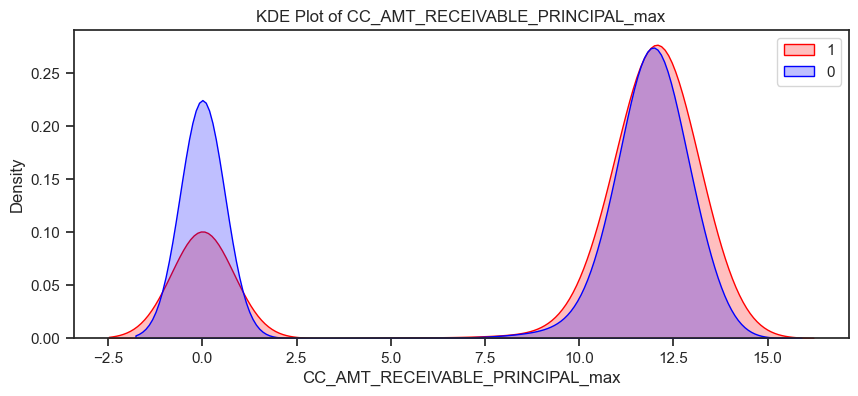

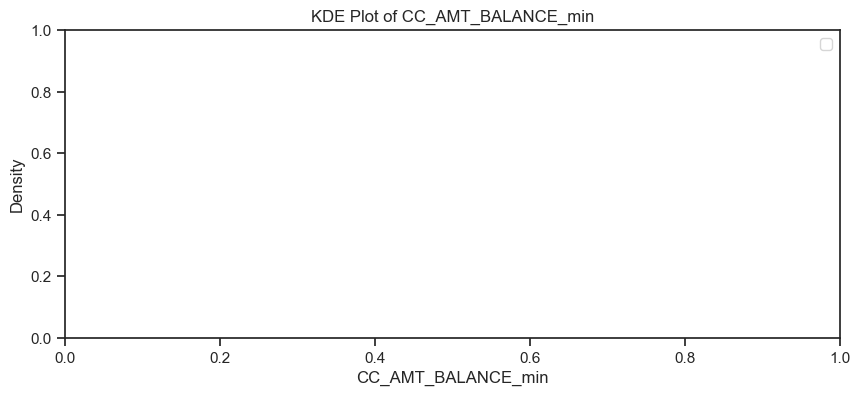

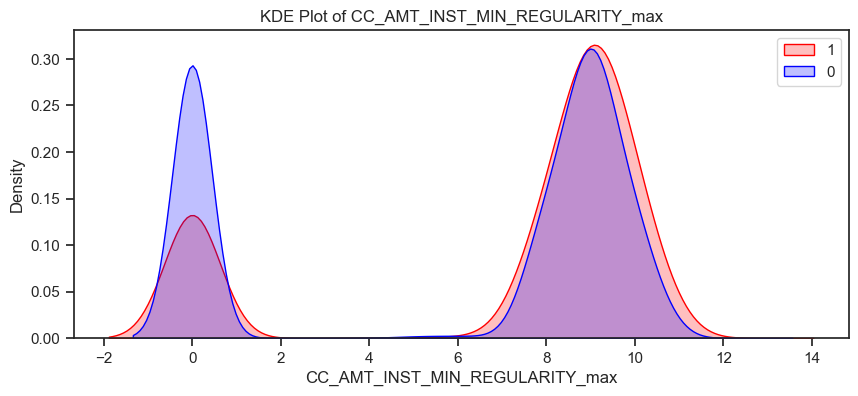

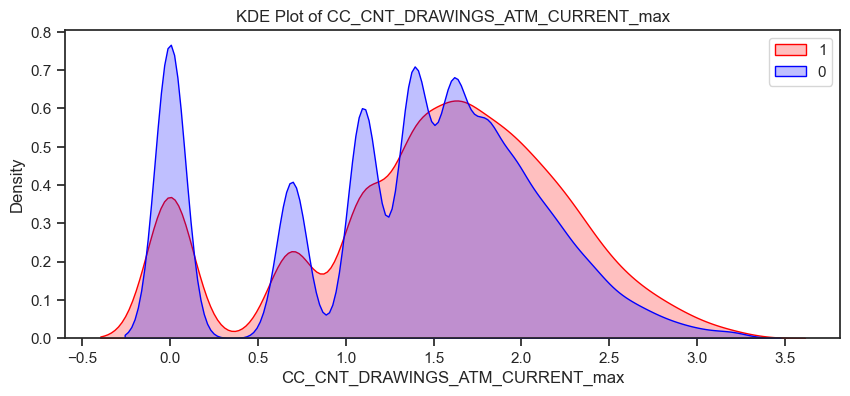

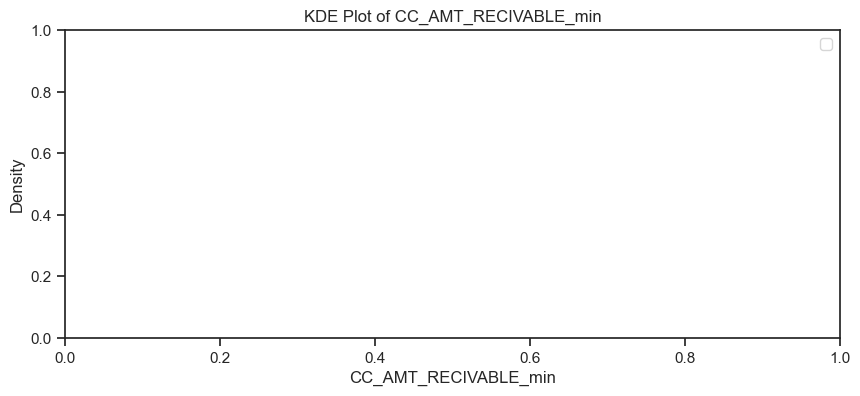

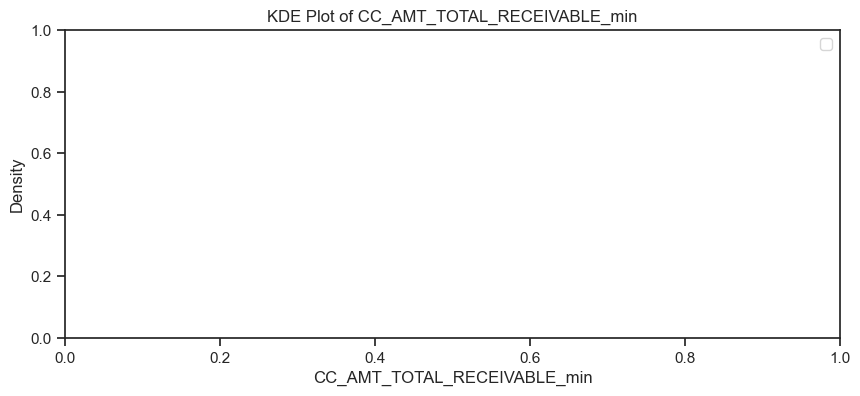

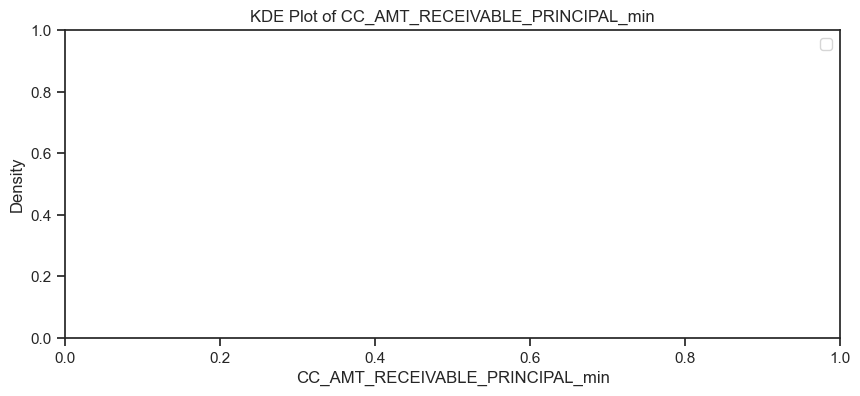

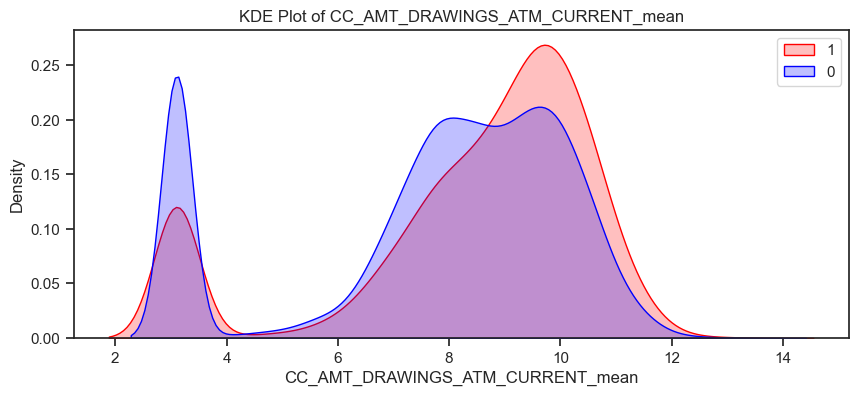

In [149]:
for column in numerical_features:
    plt.figure(figsize=(10, 4))  # Create a new figure for each feature

    # Subplot 1: KDE Plot
    sns.kdeplot(train_data[column][train_data['TARGET'] == 1], color='red', shade=True)
    sns.kdeplot(train_data[column][train_data['TARGET'] == 0], color='blue', shade=True)
    plt.legend(['1', '0'], loc='upper right')
    plt.title(f'KDE Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

    plt.show()  # Display the plot

In [151]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 15,
    'feature_fraction': 0.9,
    'verbose': -1
}
# Best Parameters: {'feature_fraction': 0.9, 'learning_rate': 0.1, 'num_leaves': 15}

In [153]:
train_all = pd.merge(train_data, train_preprocesed.drop('TARGET',axis=1), on='SK_ID_CURR', suffixes=('_left', '_right'))
test_all = pd.merge(test_data, test_preprocesed, on='SK_ID_CURR', suffixes=('_left', '_right'))

In [155]:
X = train_all.drop(columns=['SK_ID_CURR', 'TARGET'])
y = train_all['TARGET']
X_test = test_all.drop(columns=['SK_ID_CURR'])

In [157]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [163]:
X_train.shape
X_test.shape

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], callbacks=[lgb.early_stopping(30)])
preds = model.predict(X_test)


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.794468	valid_1's auc: 0.776644


In [165]:
submission = pd.DataFrame({'SK_ID_CURR': test_preprocesed['SK_ID_CURR'], 'TARGET': preds})
submission.to_csv('final_treatment_submission.csv', index=False)